In [722]:
# Suzan Iloglu, Dec 11,2020
# Positive results from Pfizer, Moderna and AstraZeneca show a vaccine can work
# In this research, we wanna show the allocation of vaccine over the us by states and then by counties
# Import packages
import csv

from itertools import product
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import time
import requests
import io
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
pd.options.display.max_columns =200
from IPython.display import Image
import sodapy
from sodapy import Socrata


# MAPPING THE VACCINE ALLOCATION
The project presents multiple options for how to distribute vaccine within each county per state. It shows that what you choose to prioritize greatly impacts where care would be sent. 
The followings are our options to choose to define vulnerability:


- SOCIAL VULNERABILITY INDEX
- MEDICAID 
- UNEMPLOYMENT
- YEARS OF POTENTIAL LIFE LOST
- TOTAL COVID CASES
- COVID CASES BY POPULATION
- COVID DEATHS BY POPULATION

We will start with Social Vulnerability Index (SVI) from CDC website.

### I. Importing SVI data which includes the variables for calculating county SVI for each state
The CDC uses both a USA-wide and a state by state SVI scores. For our project given that funding is likely going to be managed at a state level, using a state by state SVI scores makes the most sense and will be most sensitive to regional socioeconomic differences. Even though the CDC SVI scores are calculated using percentile rankings, the data sets include raw data estimates for each variables. The following table shows the variablaes used in the method of calculating SVI scores. 




      American Community Survey (ACS), 2015-2019 (5-year) data for the following estimates:
<img src="Data/img/SVI_comp.png" width="500">


Note: Full documentation for 2018 data is available <a href="https://svi.cdc.gov/data-and-tools-download.html">here</a> 
This part of the code shows preliminary mapping of <a href = "https://svi.cdc.gov/">the CDC's Social Vulnerability Index</a>.

Later in the notebook, we will provide the formula to create the SVI value we use in our project. First, we import the data for the US mainland and Puerto Rico.

In [723]:
## import svi data downloaded from CDC website as cited above

## 48 state SVI scores by county
#svi_counties_mainland = gpd.read_file("Data/SVI2018_US_COUNTY/SVI2018_US_county.shp")

## Puerto Rico SVI scores by county
#svi_counties_puerto_rico = gpd.read_file("Data/PuertoRico_COUNTY/SVI2018_PuertoRico_county.shp")

## Merge 48 states and Puerto Rico SVI 
#svi_counties = pd.concat([svi_counties_mainland,svi_counties_puerto_rico ], sort = False)
svi_counties =  pd.read_csv('Input/SVI_2019_State_Data.csv')
svi_counties.head(5)

,FIPS,COUNTY,STATE,E_NOHSDP,E_AGE17,E_POV,E_PCI,E_GROUPQ,E_AGE65,EP_AGE65,E_TOTPOP,EP_NOHSDP,EP_POV,E_UNINSUR,EP_UNINSUR,E_HH,E_DISABL,EP_DISABL,E_UNEMP,EP_UNEMP,E_HU,E_MOBILE,EP_MOBILE,E_NOVEH,EP_NOVEH,M_NOHSDP,M_AGE17,M_POV,M_PCI,M_GROUPQ,M_AGE65,MP_AGE65,M_TOTPOP,MP_NOHSDP,MP_POV,M_UNINSUR,MP_UNINSUR,M_HH,M_DISABL,MP_DISABL,M_UNEMP,MP_UNEMP,M_HU,M_MOBILE,MP_MOBILE,M_NOVEH,MP_NOVEH,ST,EP_PCI,MP_PCI,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_CROWD,M_CROWD,EP_AGE17,MP_AGE17,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_CROWD,MP_CROWD,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,SPL_THEME3_xMin,RPL_THEME3_xMin,SPL_THEMES_xMin,RPL_THEMES_xMin,RPL_rank,RPL_xMin_rank
0,1063,Greene County,Alabama,1204.0,1884,3140,14884,68,1773,21.3,8324.0,20.8,38.1,1057,12.8,2951.0,2039.0,24.7,311,11.5,5112,1828,35.8,531,18.0,241.0,13.0,537,1570,32.0,NaN,NaN,NaN,4.2,6.5,260,3.1,246.0,318.0,3.8,137,5.1,29,206,4.0,177,5.8,1,14884,1570,333.0,107.154095,6889.0,NaN,4,66.452991,299,153.287312,64,51.244512,22.633349,NaN,11.284310,3.507149,82.760692,NaN,0.051640,0.857901,5.848983,2.998395,2.168756,1.727077,0.816915,NaN,0.994906,0.954955,0.972662,0.888889,3.811412,0.985673,0.751476,0.554919,0.960840,0.987902,3.255137,0.993314,0.986310,0.076421,1.062731,0.542502,0.751476,0.975148,0.584654,0.985399,0.110793,3.407469,0.920089,11.536749,0.994269,0.076421,0.076421,10.550439,0.992677,67,67
1,1005,Barbour County,Alabama,4812.0,5307,6875,18473,2886,4710,18.6,25361.0,26.8,30.7,2544,11.3,9345.0,4806.0,21.4,849,9.2,12013,3520,29.3,950,10.2,333.0,27.0,558,942,339.0,38.0,0.1,NaN,1.8,2.4,342,1.5,313.0,369.0,1.6,176,1.9,143,255,2.0,184,2.0,1,18473,942,444.0,105.801701,13743.0,NaN,454,170.569634,208,86.023253,360,157.175062,20.925831,NaN,4.751204,1.120935,54.189504,NaN,1.890721,0.710349,1.731458,0.715788,3.852327,1.676960,11.379677,NaN,0.976441,0.913327,0.939733,0.972939,3.802439,0.984400,0.505747,0.328558,0.882840,0.274117,1.991261,0.475326,0.896530,0.736564,1.633094,0.876472,0.335508,0.930724,0.863312,0.894377,0.947787,3.971708,0.995861,11.398502,0.992359,0.736564,0.736564,10.501972,0.991722,66,66
2,1107,Pickens County,Alabama,2680.0,4031,4204,23024,1829,3739,18.5,20243.0,18.5,22.7,1697,9.1,7637.0,4657.0,25.1,802,10.3,9588,2414,25.2,787,10.3,273.0,NaN,561,1440,264.0,23.0,0.1,NaN,1.9,3.0,326,1.7,279.0,383.0,2.1,204,2.5,116,254,2.7,170,2.1,1,23024,1440,535.0,113.877127,9383.0,NaN,322,132.582050,158,69.462220,100,63.126856,19.913056,NaN,7.005369,1.468997,46.351825,NaN,1.678307,0.691034,1.647893,0.724196,1.309415,0.825207,9.035222,NaN,0.885387,0.940043,0.773221,0.814072,3.412724,0.922954,0.496738,0.225406,0.966253,0.829672,2.518069,0.786692,0.857052,0.709848,1.566900,0.846864,0.320596,0.886300,0.277726,0.896552,0.918179,3.299353,0.886979,10.797046,0.974530,0.709848,0.709848,9.939994,0.973575,64,65
3,1131,Wilcox County,Alabama,1675.0,2577,3111,16841,251,2026,19.0,10681.0,23.5,30.1,1134,10.9,3854.0,2001.0,19.2,541,15.3,5777,2333,40.4,600,15.6,204.0,NaN,417,1299,108.0,NaN,NaN,NaN,2.9,4.1,221,2.1,213.0,272.0,2.6,152,3.8,44,196,3.4,131,3.1,1,16841,1299,218.0,75.802375,7814.0,NaN,65,115.585466,8,23.021729,54,55.713553,24.126954,NaN,5.656461,1.941846,73.157944,NaN,0.649351,NaN,0.138480,0.398505,1.401142,1.443528,2.349967,NaN,0.972620,0.979807,0.958993,0.939191,3.850612,0.990767,0.548618,0.758994,0.779370,0.553327,2.640308,0.841452,0.972620,0.453557,1.426177,0.767590,0.036347,0.990991,0.316869,0.974837,0.579752,2.898795,0.701687,10.815893,0.975486,0.453557,0.453557,9.843272,0.967845,65,64
4,1105,Perry County,Alabama,1010.0,2007,2612,15055,810,1772,19.1,9293.0,17.2,30.8,846,9.3,3070.0,2016.0,22.1,290,10.1,4736,1153,24.3,399,13.0,277.0,NaN,669,2347,200.0,NaN,NaN,NaN,4.7,7.8,283,3.1,314.0,

In [724]:
## Create the list for State
S = svi_counties.STATE.unique().tolist()
if "0" in S:
    S.remove(0)
State = [str(s).strip() for s in S]
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [725]:
## Replacing -999 values with 0 for calculations
svi_county = svi_counties.fillna(0)
svi_county  = svi_county.replace(-999, 0)
svi_county['FIPS'] = svi_county['FIPS'].astype(int)
svi_county.shape

(3220, 105)

In [726]:
# Create a seperate dictionary for the variables to calculate SVI

# Persons below poverty estimate, 2014-2018 ACS
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

# Civilian (age 16+) unemployed estimate, 2014-2018 ACS
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.E_UNEMP))

# Per capita income estimate, 2014-2018 ACS
E_PCI = dict(zip(svi_county.FIPS, svi_county.E_PCI))

# Persons (age 25+) with no high school diploma estimate, 2014-2018 ACS
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.E_NOHSDP))

# Persons aged 65 and older estimate
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.E_AGE65))

# Persons aged 17 and younger estimate
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.E_AGE17))

# Population with a disability estimate
E_DISABL = dict(zip(svi_county.FIPS, svi_county.E_DISABL))

# Single parent households with children under 18 estimate
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.E_SNGPNT))

# Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.E_MINRTY))

# Persons (age 5+) who speak English "less than well" estimate, 2014-2018 ACS
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.E_LIMENG))

# Housing in structures with 10 or more units estimate, 2014-2018 ACS
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.E_MUNIT))

# Mobile homes estimate MOE, 2014-2018 ACS
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.E_MOBILE))

# At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS
E_CROWD = dict(zip(svi_county.FIPS, svi_county.E_CROWD))

# Households with no vehicle available estimate, 2014-2018 ACS
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.E_NOVEH))

# Persons in institutionalized group quarters estimate, 2014-2018 ACS
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.E_GROUPQ))

# Percentage of persons below poverty estimate
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

In [727]:
df_mmm = pd.read_csv("Input/ACSST5Y2019.S2704_data_with_overlays_2020-12-11T225641.csv", header=[1])
df_mmm.head(1)
#df_mmm.dtypes

,id,Geographic Area Name,Estimate!!Total!!Civilian noninstitutionalized population,Margin of Error!!Total!!Civilian noninstitutionalized population,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,"Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)","Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)",Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALON

In [728]:

pandemic_i = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201215_results.csv")

#pandemic_index[['Name','NAME']] = pandemic_index['Name'].str.split(',',expand=True)
pandemic_i.head(5)

,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff
0,0.638253,7,8,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080
1,0.635230,7,2,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683
2,0.634814,7,2,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602
3,0.634474,7,2,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750
4,0.628516,7,8,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126


In [729]:
pandemic_input = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201216_data.csv", header = [12])


pandemic_input.head(5)


,row,sid,casrn,name,Spread,Sick,PctCases,Cases,CountyCaseRate,StateCaseRate,PctDeaths,Deaths,PctDeaths2,CountyDeathRate,StateDeathRate,StatePctTested,StateTestRate,SVISocioeconomic,SVIMinority,SVIHousing,PctBeds,Mobility,PctNoIns,PctGE65,DaytimePopDensity,PrematureDeath,Smoking,AirPollution,Diabetes,Traffic,DistancingGrade,Obesity,PctBlack,PctNative
0,1,"-86.6441,32.5395",1001,"Alabama, Autauga",0.177466,10.935055,0.061618,3426,1.014996,1.012372,0.012551,43,0.000773,1.006827,1.006616,0.354384,1.005746,0.3631,0.5947,0.3741,0.001529,1733.08,7.1,14.6,76.0,8128.591190,0.180816,11.7,0.111,88.457040,5.0,0.333,0.193432,0.004802
1,2,"-87.7221,30.7277",1003,"Alabama, Baldwin",0.181720,9.219253,0.050733,11061,1.014887,1.012372,0.012747,141,0.000647,1.000000,1.006616,0.354384,1.005746,0.2232,0.4358,0.3359,0.001523,1971.57,10.2,19.5,121.0,7354.122530,0.174890,10.3,0.107,86.997430,5.0,0.310,0.087840,0.007724
2,3,"-85.3871,31.8683",1005,"Alabama, Barbour",0.079721,4.139705,0.051927,1292,1.005886,1.012372,0.023220,30,0.001206,1.000000,1.006616,0.354384,1.005746,0.9780,0.8558,0.9889,0.002974,1080.54,11.2,18.0,27.5,10253.573403,0.220000,11.5,0.176,102.291762,3.7,0.417,0.480326,0.006591
3,4,"-87.1251,32.9964",1007,"Alabama, Bibb",0.199468,13.392857,0.067143,1504,1.019148,1.012372,0.025931,39,0.001741,1.000000,1.006616,0.354384,1.005746,0.7694,0.4323,0.7189,0.001563,1272.47,7.9,16.3,28.9,11977.539484,0.191142,11.2,0.145,29.335580,4.0,0.376,0.211205,0.004375
4,5,"-86.5679,33.9821",1009,"Alabama, Blount",0.211286,14.177040,0.067099,3881,1.017974,1.012372,0.012626,49,0.000847,1.009066,1.006616,0.354384,1.005746,0.6143,0.5915,0.1741,0.000692,1395.46,11.0,17.8,71.7,11335.071134,0.192087,11.7,0.170,33.411782,4.3,0.338,0.014627,0.006535


In [730]:
pandemic_in = pd.merge(left = pandemic_i, right = pandemic_input[['sid', 'casrn']], how = 'left', left_on = 'Source', right_on = 'sid')

pandemic_in.head(5)



,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff,sid,casrn
0,0.638253,7,8,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080,"-89.1173,32.7534",28099
1,0.635230,7,2,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683,"-86.1689,33.3782",1121
2,0.634814,7,2,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602,"-80.917,36.666",51640
3,0.634474,7,2,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750,"-94.7638,39.1173",20209
4,0.628516,7,8,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126,"-89.524,32.7537",28079


In [731]:
PVI_county = dict(zip(pandemic_in.casrn, pandemic_in['ToxPi Score']))


In [732]:
ADI =  pd.read_csv('Input/ADI_2019.csv')
ADI.head(5)

,GEOID,NAME,STATE,ADI_US,ADI_ST,ADI_US_Scaled,ADI_ST_Scaled,st,ADI_US_rank,ADI_ST_rank
0,1001,Autauga County,Alabama,90.180531,68.898514,40.14,4.86,1,5,5.0
1,1003,Baldwin County,Alabama,83.132327,55.593936,36.20,4.70,1,2,2.0
2,1005,Barbour County,Alabama,133.749446,129.732504,64.48,5.58,1,64,64.0
3,1007,Bibb County,Alabama,111.576263,100.930506,52.09,5.24,1,33,33.0
4,1009,Blount County,Alabama,101.762939,87.270465,46.61,5.08,1,13,14.0


In [733]:
df_mmm['FIPS'] = df_mmm.id.astype(str).str[9:]
df_mmm.head(5)
df_mmm.FIPS.astype(int)
df_mmm['FIPS'] = pd.to_numeric(df_mmm['FIPS'])

In [734]:
#2019 ADI data
ADI_county  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination"]))

df_a = pd.read_csv("Input/ACSST5Y2019.S0101_data_with_overlays_2020-12-15T094007.csv", header=[1])
df_a.head(1)


# 2018
# ADI_total  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination"]))

,id,FIPS,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total!!Total population!!AGE!!20 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 29 years,Margin of Error!!Total!!Total population!!AGE!!25 to 29 years,Estimate!!Total!!Total population!!AGE!!30 to 34 years,Margin of Error!!Total!!Total population!!AGE!!30 to 34 years,Estimate!!Total!!Total population!!AGE!!35 to 39 years,Margin of Error!!Total!!Total population!!AGE!!35 to 39 years,Estimate!!Total!!Total population!!AGE!!40 to 44 years,Margin of Error!!Total!!Total population!!AGE!!40 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 49 years,Margin of Error!!Total!!Total population!!AGE!!45 to 49 years,Estimate!!Total!!Total population!!AGE!!50 to 54 years,Margin of Error!!Total!!Total population!!AGE!!50 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 59 years,Margin of Error!!Total!!Total population!!AGE!!55 to 59 years,Estimate!!Total!!Total population!!AGE!!60 to 64 years,Margin of Error!!Total!!Total population!!AGE!!60 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 69 years,Margin of Error!!Total!!Total population!!AGE!!65 to 69 years,Estimate!!Total!!Total population!!AGE!!70 to 74 years,Margin of Error!!Total!!Total population!!AGE!!70 to 74 years,Estimate!!Total!!Total population!!AGE!!75 to 79 years,Margin of Error!!Total!!Total population!!AGE!!75 to 79 years,Estimate!!Total!!Total population!!AGE!!80 to 84 years,Margin of Error!!Total!!Total population!!AGE!!80 to 84 years,Estimate!!Total!!Total population!!AGE!!85 years and over,Margin of Error!!Total!!Total population!!AGE!!85 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Estimate!!Total!!Total popul

In [735]:
#Adult population
Sixty_five_plus_pop = dict(zip(df_a['FIPS'], df_a["Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over"]))
Sixty_five_plus_pop

{1001: 8283,
 1003: 42531,
 1005: 4710,
 1007: 3584,
 1009: 10326,
 1011: 1640,
 1013: 3900,
 1015: 19738,
 1017: 6470,
 1019: 5811,
 1021: 7052,
 1023: 2922,
 1025: 4679,
 1027: 2698,
 1029: 2899,
 1031: 8550,
 1033: 10644,
 1035: 2746,
 1037: 2430,
 1039: 7726,
 1041: 2609,
 1043: 15116,
 1045: 8081,
 1047: 6809,
 1049: 11883,
 1051: 12053,
 1053: 6566,
 1055: 19257,
 1057: 3438,
 1059: 5304,
 1061: 5275,
 1063: 1773,
 1065: 2777,
 1067: 3785,
 1069: 18052,
 1071: 10113,
 1073: 101785,
 1075: 2983,
 1077: 18228,
 1079: 5998,
 1081: 18696,
 1083: 14328,
 1085: 1856,
 1087: 3614,
 1089: 53151,
 1091: 3729,
 1093: 6288,
 1095: 16093,
 1097: 65339,
 1099: 4100,
 1101: 33107,
 1103: 20412,
 1105: 1772,
 1107: 3739,
 1109: 4946,
 1111: 4622,
 1113: 8029,
 1115: 14317,
 1117: 31716,
 1119: 2234,
 1121: 14052,
 1123: 8505,
 1125: 26673,
 1127: 12191,
 1129: 3047,
 1131: 2026,
 1133: 5075,
 2013: 318,
 2016: 347,
 2020: 30873,
 2050: 1301,
 2060: 87,
 2068: 209,
 2070: 499,
 2090: 9699,
 2100

In [736]:
df_a = df_a.rename(columns = {"Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over":'Adult_pop'})
df_a.head(5)
df_a.shape


(3220, 459)

In [737]:
#Adult population
Adult_pop_county = dict(zip(df_a['FIPS'], df_a["Adult_pop"]))
Adult_pop_county

{1001: 42175,
 1003: 166595,
 1005: 20054,
 1007: 17862,
 1009: 44292,
 1011: 8120,
 1013: 15373,
 1015: 89666,
 1017: 26595,
 1019: 20658,
 1021: 33420,
 1023: 10322,
 1025: 18841,
 1027: 10559,
 1029: 11533,
 1031: 39403,
 1033: 43218,
 1035: 9790,
 1037: 8956,
 1039: 29037,
 1041: 10738,
 1043: 64148,
 1045: 37892,
 1047: 29720,
 1049: 53800,
 1051: 62915,
 1053: 28769,
 1055: 80579,
 1057: 13014,
 1059: 23582,
 1061: 20599,
 1063: 6440,
 1065: 11355,
 1067: 13537,
 1069: 80349,
 1071: 40870,
 1073: 508503,
 1075: 10835,
 1077: 74247,
 1079: 25875,
 1081: 126764,
 1083: 73144,
 1085: 7808,
 1087: 15460,
 1089: 282589,
 1091: 14918,
 1093: 23592,
 1095: 71756,
 1097: 316303,
 1099: 16522,
 1101: 173501,
 1103: 91846,
 1105: 7286,
 1107: 16212,
 1109: 26863,
 1111: 17751,
 1113: 43783,
 1115: 67948,
 1117: 162807,
 1119: 10327,
 1121: 63130,
 1123: 32072,
 1125: 163687,
 1127: 49854,
 1129: 12753,
 1131: 8104,
 1133: 18858,
 2013: 2901,
 2016: 4716,
 2020: 221655,
 2050: 11740,
 2060:

In [738]:
#Total number of health workers

Health_workers = pd.read_csv("Input/Healthcare_Personnel_2018.csv")

Health_workers = pd.merge(Health_workers, svi_county[['FIPS']], how='right', on=['FIPS'])
Health_workers['FIPS'] = Health_workers['FIPS'].astype(str)
Health_workers.fillna(0, inplace=True)
Health_workers.head(5)
Health_workers.shape

(3220, 9)

In [739]:
Health_workers.dtypes

GEO_ID              object
FIPS                object
NAME                object
STATE               object
NAICS2017          float64
NAICS2017_LABEL     object
EMPSZES_LABEL       object
YEAR               float64
EMP                float64
dtype: object

In [740]:
import folium
import json
import pandas as pd
import os

#county_geo = os.path.join('Input/us-county-boundaries.json')
#county_geo

In [741]:
Assistant_Living = pd.read_csv("Input/Assistant_Living.csv")

Assistant_Living['FIPS'] = Assistant_Living['FIPS'].astype(str)

Assistant_Living['est_patients'] = Assistant_Living['est_patients'].replace(math.nan, 0)


# Population

In [742]:


#first_phase = pd.merge(Health_workers, Assistant_Living, how='outer', on=['FIPS'])
#first_phase.fillna(0, inplace=True)

#sum_column = first_phase["EMP"] + first_phase["est_patients"]
#first_phase["one_a"] = sum_column

first_phase = pd.read_csv("Input/Phase_1a_pop.csv")

first_phase['FIPS'] = first_phase['FIPS'].astype(int)
first_phase.head(5)

,FIPS,hp_emp,ltcf_res,phase_1a
0,1001,1037,120,1157
1,1003,7214,680,7894
2,1005,422,143,565
3,1007,418,119,537
4,1009,661,202,863


In [743]:
Firstphase_county = dict(zip(first_phase.FIPS, first_phase.phase_1a))

In [744]:
from collections import Counter
Asistant_Living_county = dict(zip(Assistant_Living['FIPS'], Assistant_Living["est_patients"]))
Health_workers_county = dict(zip(Health_workers['FIPS'], Health_workers["EMP"]))

one_a = dict(Counter(Asistant_Living_county)+Counter(Health_workers_county))

one_a

{'1003': 9161.0,
 '1009': 1009.0,
 '1013': 1260.0,
 '1015': 6513.0,
 '1017': 875.0,
 '1031': 1977.0,
 '1033': 3140.0,
 '1043': 4140.0,
 '1049': 2712.0,
 '1053': 1278.0,
 '1055': 7339.0,
 '1057': 761.0,
 '1061': 642.0,
 '1069': 9692.0,
 '1073': 69725.0,
 '1077': 5028.0,
 '1081': 6783.0,
 '1083': 2600.0,
 '1089': 27361.0,
 '1093': 1105.0,
 '1097': 22012.0,
 '1101': 18355.0,
 '1103': 6217.0,
 '1117': 7558.0,
 '1121': 3304.0,
 '1125': 13156.0,
 '2020': 27653.0,
 '2090': 6347.0,
 '2122': 4322.0,
 '2170': 4740.0,
 '4001': 2470.0,
 '4003': 4890.0,
 '4005': 9797.0,
 '4007': 2138.0,
 '4013': 262947.0,
 '4015': 9186.0,
 '4017': 4875.0,
 '4019': 66055.0,
 '4021': 9640.0,
 '4023': 1720.0,
 '4025': 14633.0,
 '4027': 8085.0,
 '5003': 942.0,
 '5005': 4235.0,
 '5007': 10950.0,
 '5009': 2692.0,
 '5017': 765.0,
 '5023': 981.0,
 '5031': 10507.0,
 '5033': 1638.0,
 '5045': 6352.0,
 '5051': 9194.0,
 '5063': 3876.0,
 '5069': 4213.0,
 '5091': 981.0,
 '5115': 4016.0,
 '5119': 47105.0,
 '5125': 4971.0,
 '5131':

In [745]:
# Read the Population data
df_pop = pd.read_csv("Input/County_pop_2019.csv")

# Fill NA with 0
df_pop = df_pop.fillna(0)


In [746]:
# Create a dictionary for the county and population
population_county = df_pop.set_index('FIPS')['pop'].to_dict()

In [747]:

# Create a dictionary for the states of the given the county FIPS
county_of_states = dict(zip(svi_county.FIPS, svi_county.STATE))

# Create a dictionary for the name of the given the county FIPS
county_name = dict(zip(svi_county.FIPS, svi_county.COUNTY))

# Create the list for county FIPS, we consider counties as analogy to the center for community health workers
location = svi_county.FIPS.tolist() #[k for k in SVI_county] #[9001, 9003, 9005, 9007, 9009, 9011, 9013, 9015]#[k for k in SVI_county]




In [748]:
location

[1063,
 1005,
 1107,
 1131,
 1105,
 1065,
 1119,
 1123,
 1085,
 1047,
 1121,
 1087,
 1059,
 1023,
 1093,
 1025,
 1133,
 1113,
 1021,
 1053,
 1127,
 1075,
 1039,
 1017,
 1061,
 1057,
 1109,
 1091,
 1007,
 1049,
 1011,
 1015,
 1111,
 1045,
 1101,
 1035,
 1129,
 1013,
 1099,
 1055,
 1103,
 1079,
 1071,
 1097,
 1043,
 1029,
 1037,
 1041,
 1095,
 1067,
 1027,
 1031,
 1069,
 1083,
 1125,
 1019,
 1081,
 1073,
 1009,
 1077,
 1051,
 1115,
 1001,
 1033,
 1003,
 1089,
 1117,
 2050,
 2188,
 2180,
 2158,
 2070,
 2290,
 2198,
 2240,
 2275,
 2185,
 2164,
 2282,
 2195,
 2122,
 2150,
 2105,
 2100,
 2130,
 2013,
 2220,
 2020,
 2090,
 2170,
 2016,
 2261,
 2060,
 2068,
 2110,
 2230,
 4017,
 4027,
 4012,
 4001,
 4003,
 4007,
 4015,
 4009,
 4023,
 4019,
 4021,
 4025,
 4005,
 4011,
 4013,
 5017,
 5127,
 5123,
 5041,
 5011,
 5027,
 5071,
 5095,
 5077,
 5141,
 5107,
 5113,
 5057,
 5093,
 5069,
 5073,
 5097,
 5147,
 5049,
 5091,
 5051,
 5059,
 5063,
 5061,
 5035,
 5067,
 5149,
 5133,
 5083,
 5131,
 5029,
 5135,

In [749]:
#Parameters
cartesian_pro_county_state = [(i,county_of_states[i]) for i in location ]
cartesian_pro_county_state


[(1063, 'Alabama'),
 (1005, 'Alabama'),
 (1107, 'Alabama'),
 (1131, 'Alabama'),
 (1105, 'Alabama'),
 (1065, 'Alabama'),
 (1119, 'Alabama'),
 (1123, 'Alabama'),
 (1085, 'Alabama'),
 (1047, 'Alabama'),
 (1121, 'Alabama'),
 (1087, 'Alabama'),
 (1059, 'Alabama'),
 (1023, 'Alabama'),
 (1093, 'Alabama'),
 (1025, 'Alabama'),
 (1133, 'Alabama'),
 (1113, 'Alabama'),
 (1021, 'Alabama'),
 (1053, 'Alabama'),
 (1127, 'Alabama'),
 (1075, 'Alabama'),
 (1039, 'Alabama'),
 (1017, 'Alabama'),
 (1061, 'Alabama'),
 (1057, 'Alabama'),
 (1109, 'Alabama'),
 (1091, 'Alabama'),
 (1007, 'Alabama'),
 (1049, 'Alabama'),
 (1011, 'Alabama'),
 (1015, 'Alabama'),
 (1111, 'Alabama'),
 (1045, 'Alabama'),
 (1101, 'Alabama'),
 (1035, 'Alabama'),
 (1129, 'Alabama'),
 (1013, 'Alabama'),
 (1099, 'Alabama'),
 (1055, 'Alabama'),
 (1103, 'Alabama'),
 (1079, 'Alabama'),
 (1071, 'Alabama'),
 (1097, 'Alabama'),
 (1043, 'Alabama'),
 (1029, 'Alabama'),
 (1037, 'Alabama'),
 (1041, 'Alabama'),
 (1095, 'Alabama'),
 (1067, 'Alabama'),


In [750]:
###############################################################################################
######################## END calculating different types of vulnerabilities ###################

Since we allocate CHW proportional to the county values of certain vulnaribilites within state, we need a few function to help us with the calculations. 



In [751]:
# This function return the value for the state for the given dictionary

# More specifically sum upt the values for the counties of each state

def total_state(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [752]:
Adult_pop_state = total_state(Adult_pop_county)
Adult_pop_state

{'Alabama': 3779874.0,
 'Alaska': 552674.0,
 'Arizona': 5414955.0,
 'Arkansas': 2295102.0,
 'California': 30261351.0,
 'Colorado': 4349344.0,
 'Connecticut': 2831241.0,
 'Delaware': 753564.0,
 'District of Columbia': 568753.0,
 'Florida': 16719174.0,
 'Georgia': 7898607.0,
 'Hawaii': 1117456.0,
 'Idaho': 1276603.0,
 'Illinois': 9879105.0,
 'Indiana': 5093212.0,
 'Iowa': 2410771.0,
 'Kansas': 2199582.0,
 'Kentucky': 3439746.0,
 'Louisiana': 3561012.0,
 'Maine': 1082994.0,
 'Maryland': 4677166.0,
 'Massachusetts': 5479293.0,
 'Michigan': 7787387.0,
 'Minnesota': 4267530.0,
 'Mississippi': 2270925.0,
 'Missouri': 4723298.0,
 'Montana': 822263.0,
 'Nebraska': 1440464.0,
 'Nevada': 2291340.0,
 'New Hampshire': 1088160.0,
 'New Jersey': 6916982.0,
 'New Mexico': 1603978.0,
 'New York': 15463820.0,
 'North Carolina': 7968262.0,
 'North Dakota': 580973.0,
 'Ohio': 9050387.0,
 'Oklahoma': 2975906.0,
 'Oregon': 3261860.0,
 'Pennsylvania': 10129139.0,
 'Rhode Island': 849887.0,
 'South Carolina':

In [753]:
PVI_State = total_state(PVI_county)
PVI_State

{'Alabama': 38.572279234423554,
 'Alaska': 11.55568830148408,
 'Arizona': 8.216711289744909,
 'Arkansas': 39.76807721216496,
 'California': 28.505417381617598,
 'Colorado': 27.976972802721207,
 'Connecticut': 3.6567771096868324,
 'Delaware': 1.5718680965808252,
 'District of Columbia': 0.4965435851841808,
 'Florida': 35.25547094541446,
 'Georgia': 83.93564153885464,
 'Hawaii': 1.6022581849548165,
 'Idaho': 20.91043575968721,
 'Illinois': 48.28471381480609,
 'Indiana': 46.39090147414818,
 'Iowa': 46.78083286020223,
 'Kansas': 51.04329308526995,
 'Kentucky': 60.971219942183104,
 'Louisiana': 34.520484732352195,
 'Maine': 6.649441908799711,
 'Maryland': 11.458502805521354,
 'Massachusetts': 6.11656826971036,
 'Michigan': 39.267762475748846,
 'Minnesota': 38.05233817074998,
 'Mississippi': 46.8235669935997,
 'Missouri': 56.74297932811081,
 'Montana': 23.360475817266114,
 'Nebraska': 36.960664709840714,
 'Nevada': 8.179083715147337,
 'New Hampshire': 4.3687420855632375,
 'New Jersey': 10.50

In [754]:
Firstphase_State = total_state(Firstphase_county)




In [755]:
# We consider allocation of 11 million vaccine all over the US
Federal_budget_Vaccine = 2900000

# First, we calculate the Total Medicaid enrolles all over the US
Total_federal_need = sum(Adult_pop_state[s] for s in State)
Total_federal_need
# Allocate the 1 million CHWs proportional to Medicaid enrolles in each state
#Vaccine_budget_state = {s: (Adult_pop_state[s]/Total_federal_need)*Federal_budget_Vaccine  for s in State}
#Vaccine_budget_state
#t= sum(Vaccine_budget_state[s] for s in State)
#t


253938504.0

In [756]:
vac = pd.read_csv('https://data.cdc.gov/resource/saz5-9hgg.csv')
vac['jurisdiction'] = vac['jurisdiction'].str.replace("*", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("**", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("***", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("****", "")
vac.dropna(subset = ['total_pfizer_allocation_first_dose_shipments'], inplace=True)
vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace(",", "")
#vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace("", "0")
vac['first_doses'] = vac['first_doses'].astype(int)
vac.head(50)



,jurisdiction,hhs_region,first_doses_12_14,second_doses_shipment_12_14,doses_allocated_week_of_12_21,second_dose_shipment_12_17,doses_allocated_week_of_12_28,second_dose_shipment_12_28,doses_allocated_week_of_01_04,second_dose_shipment_01_04,doses_allocated_week_of_01_10,second_dose_shipment_week_of_01_10,total_pfizer_allocation_first_dose_shipments,total_allocation_pfizer_second_dose_shipments,first_doses
0,Connecticut,Region 1,"31,200","31,200","22,425","22,425","28,275","28,275","22,425","22,425","22,425","22,425","126,750","126,750",126750
1,Maine,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","8,775","8,775","49,725","49,725",49725
2,Massachusetts,Region 1,"59,475","59,475","42,900","42,900","54,600","54,600","42,900","42,900","42,900","42,900","242,775","242,775",242775
3,New Hampshire,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","8,775","8,775","49,725","49,725",49725
4,Rhode Island,Region 1,"9,750","9,750","6,825","6,825","8,775","8,775","6,825","6,825","6,825","6,825","39,000","39,000",39000
5,Vermont,Region 1,"5,850","5,850","4,875","4,875","5,850","5,850","3,900","3,900","4,875","4,875","25,350","25,350",25350
6,New Jersey,Region 2,"76,050","76,050","53,625","53,625","68,250","68,250","53,625","53,625","53,625","53,625","305,175","305,175",305175
7,New York,Region 2,"96,525","96,525","68,250","68,250","87,750","87,750","68,250","68,250","68,250","68,250","389,025","389,025",389025
8,New York City,Region 2,"73,125","73,125","51,675","51,675","66,300","66,300","51,675","51,675","51,675","51,675","294,450","294,450",294450
9,Puerto Rico,Region 2,"30,225","30,225","21,450","21,450","27,300","27,300","21,450","21,450","21,450","21,450","121,875","121,875",121875


In [757]:

Jur_state = {'New York City': 'New York', 'Philadelphia': 'Pennsylvania', 'Chicago':'Illinois'}
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [758]:

Vaccine_budget_state = {s:0 for s in State}


Vaccine_budget_st =  dict(zip(vac.jurisdiction, vac.first_doses) )

for s in Vaccine_budget_st:
    
    if s in State:
       # print(s)
        Vaccine_budget_state[s] = Vaccine_budget_st[s]
    
    if s in Jur_state:
        
        
        Vaccine_budget_state[Jur_state[s]] += Vaccine_budget_st[s]
        


In [759]:
county_of_states




{1063: 'Alabama',
 1005: 'Alabama',
 1107: 'Alabama',
 1131: 'Alabama',
 1105: 'Alabama',
 1065: 'Alabama',
 1119: 'Alabama',
 1123: 'Alabama',
 1085: 'Alabama',
 1047: 'Alabama',
 1121: 'Alabama',
 1087: 'Alabama',
 1059: 'Alabama',
 1023: 'Alabama',
 1093: 'Alabama',
 1025: 'Alabama',
 1133: 'Alabama',
 1113: 'Alabama',
 1021: 'Alabama',
 1053: 'Alabama',
 1127: 'Alabama',
 1075: 'Alabama',
 1039: 'Alabama',
 1017: 'Alabama',
 1061: 'Alabama',
 1057: 'Alabama',
 1109: 'Alabama',
 1091: 'Alabama',
 1007: 'Alabama',
 1049: 'Alabama',
 1011: 'Alabama',
 1015: 'Alabama',
 1111: 'Alabama',
 1045: 'Alabama',
 1101: 'Alabama',
 1035: 'Alabama',
 1129: 'Alabama',
 1013: 'Alabama',
 1099: 'Alabama',
 1055: 'Alabama',
 1103: 'Alabama',
 1079: 'Alabama',
 1071: 'Alabama',
 1097: 'Alabama',
 1043: 'Alabama',
 1029: 'Alabama',
 1037: 'Alabama',
 1041: 'Alabama',
 1095: 'Alabama',
 1067: 'Alabama',
 1027: 'Alabama',
 1031: 'Alabama',
 1069: 'Alabama',
 1083: 'Alabama',
 1125: 'Alabama',
 1019: 'Al

In [760]:
Vaccine_budget_state

{'Alabama': 166725,
 'Alaska': 62400,
 'Arizona': 237900,
 'Arkansas': 104325,
 'California': 1323075,
 'Colorado': 189150,
 'Connecticut': 126750,
 'Delaware': 34125,
 'District of Columbia': 27300,
 'Florida': 724425,
 'Georgia': 343200,
 'Hawaii': 50700,
 'Idaho': 55575,
 'Illinois': 345150,
 'Indiana': 225225,
 'Iowa': 108225,
 'Kansas': 99450,
 'Kentucky': 154050,
 'Louisiana': 159900,
 'Maine': 49725,
 'Maryland': 205725,
 'Massachusetts': 242775,
 'Michigan': 343200,
 'Minnesota': 189150,
 'Mississippi': 100425,
 'Missouri': 209625,
 'Montana': 39000,
 'Nebraska': 66300,
 'Nevada': 100425,
 'New Hampshire': 49725,
 'New Jersey': 305175,
 'New Mexico': 72150,
 'New York': 683475,
 'North Carolina': 348075,
 'North Dakota': 27300,
 'Ohio': 398775,
 'Oklahoma': 132600,
 'Oregon': 143325,
 'Pennsylvania': 449475,
 'Rhode Island': 39000,
 'South Carolina': 172575,
 'South Dakota': 32175,
 'Tennessee': 228150,
 'Texas': 906750,
 'Utah': 94575,
 'Vermont': 25350,
 'Virginia': 289575,
 

In [761]:
# Calculte the population per state by summing up the population in each county in the state
State_pop = total_state(population_county)


In [762]:


# This function returns the ratio of the dict value for county and state of the county
def Proportional(county_level, state_level):
    
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = (float(county_level[j])/float(state_level[s]))*100    
        else:
            prop[j] = 0
                
    return prop

In [763]:
def SVI_prop(county_level, state_level):
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = float(county_level[j])*float(state_level[s])    
        else:
            prop[j] = 0
                
    return prop
        

In [764]:
#ADI
ADI_State = total_state(ADI_county)

In [765]:
svi_county.head(5)

,FIPS,COUNTY,STATE,E_NOHSDP,E_AGE17,E_POV,E_PCI,E_GROUPQ,E_AGE65,EP_AGE65,E_TOTPOP,EP_NOHSDP,EP_POV,E_UNINSUR,EP_UNINSUR,E_HH,E_DISABL,EP_DISABL,E_UNEMP,EP_UNEMP,E_HU,E_MOBILE,EP_MOBILE,E_NOVEH,EP_NOVEH,M_NOHSDP,M_AGE17,M_POV,M_PCI,M_GROUPQ,M_AGE65,MP_AGE65,M_TOTPOP,MP_NOHSDP,MP_POV,M_UNINSUR,MP_UNINSUR,M_HH,M_DISABL,MP_DISABL,M_UNEMP,MP_UNEMP,M_HU,M_MOBILE,MP_MOBILE,M_NOVEH,MP_NOVEH,ST,EP_PCI,MP_PCI,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_CROWD,M_CROWD,EP_AGE17,MP_AGE17,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_CROWD,MP_CROWD,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,SPL_THEME3_xMin,RPL_THEME3_xMin,SPL_THEMES_xMin,RPL_THEMES_xMin,RPL_rank,RPL_xMin_rank
0,1063,Greene County,Alabama,1204.0,1884,3140,14884,68,1773,21.3,8324.0,20.8,38.1,1057,12.8,2951.0,2039.0,24.7,311,11.5,5112,1828,35.8,531,18.0,241.0,13.0,537,1570,32.0,0.0,0.0,0.0,4.2,6.5,260,3.1,246.0,318.0,3.8,137,5.1,29,206,4.0,177,5.8,1,14884,1570,333.0,107.154095,6889.0,0.0,4,66.452991,299,153.287312,64,51.244512,22.633349,0.0,11.284310,3.507149,82.760692,0.0,0.051640,0.857901,5.848983,2.998395,2.168756,1.727077,0.816915,0.0,0.994906,0.954955,0.972662,0.888889,3.811412,0.985673,0.751476,0.554919,0.960840,0.987902,3.255137,0.993314,0.986310,0.076421,1.062731,0.542502,0.751476,0.975148,0.584654,0.985399,0.110793,3.407469,0.920089,11.536749,0.994269,0.076421,0.076421,10.550439,0.992677,67,67
1,1005,Barbour County,Alabama,4812.0,5307,6875,18473,2886,4710,18.6,25361.0,26.8,30.7,2544,11.3,9345.0,4806.0,21.4,849,9.2,12013,3520,29.3,950,10.2,333.0,27.0,558,942,339.0,38.0,0.1,0.0,1.8,2.4,342,1.5,313.0,369.0,1.6,176,1.9,143,255,2.0,184,2.0,1,18473,942,444.0,105.801701,13743.0,0.0,454,170.569634,208,86.023253,360,157.175062,20.925831,0.0,4.751204,1.120935,54.189504,0.0,1.890721,0.710349,1.731458,0.715788,3.852327,1.676960,11.379677,0.0,0.976441,0.913327,0.939733,0.972939,3.802439,0.984400,0.505747,0.328558,0.882840,0.274117,1.991261,0.475326,0.896530,0.736564,1.633094,0.876472,0.335508,0.930724,0.863312,0.894377,0.947787,3.971708,0.995861,11.398502,0.992359,0.736564,0.736564,10.501972,0.991722,66,66
2,1107,Pickens County,Alabama,2680.0,4031,4204,23024,1829,3739,18.5,20243.0,18.5,22.7,1697,9.1,7637.0,4657.0,25.1,802,10.3,9588,2414,25.2,787,10.3,273.0,0.0,561,1440,264.0,23.0,0.1,0.0,1.9,3.0,326,1.7,279.0,383.0,2.1,204,2.5,116,254,2.7,170,2.1,1,23024,1440,535.0,113.877127,9383.0,0.0,322,132.582050,158,69.462220,100,63.126856,19.913056,0.0,7.005369,1.468997,46.351825,0.0,1.678307,0.691034,1.647893,0.724196,1.309415,0.825207,9.035222,0.0,0.885387,0.940043,0.773221,0.814072,3.412724,0.922954,0.496738,0.225406,0.966253,0.829672,2.518069,0.786692,0.857052,0.709848,1.566900,0.846864,0.320596,0.886300,0.277726,0.896552,0.918179,3.299353,0.886979,10.797046,0.974530,0.709848,0.709848,9.939994,0.973575,64,65
3,1131,Wilcox County,Alabama,1675.0,2577,3111,16841,251,2026,19.0,10681.0,23.5,30.1,1134,10.9,3854.0,2001.0,19.2,541,15.3,5777,2333,40.4,600,15.6,204.0,0.0,417,1299,108.0,0.0,0.0,0.0,2.9,4.1,221,2.1,213.0,272.0,2.6,152,3.8,44,196,3.4,131,3.1,1,16841,1299,218.0,75.802375,7814.0,0.0,65,115.585466,8,23.021729,54,55.713553,24.126954,0.0,5.656461,1.941846,73.157944,0.0,0.649351,0.000000,0.138480,0.398505,1.401142,1.443528,2.349967,0.0,0.972620,0.979807,0.958993,0.939191,3.850612,0.990767,0.548618,0.758994,0.779370,0.553327,2.640308,0.841452,0.972620,0.453557,1.426177,0.767590,0.036347,0.990991,0.316869,0.974837,0.579752,2.898795,0.701687,10.815893,0.975486,0.453557,0.453557,9.843272,0.967845,65,64
4,1105,Perry County,Alabama,1010.0,2007,2612,15055,810,1772,19.1,9293.0,17.2,30.8,846,9.3,3070.0,2016.0,22.1,290,10.1,4736,1153,24.3,399,13.0,277.0,0.0,669,2347,200.0,0.0,0.0,0.0,4.7,7.8,283,3.1,3

In [766]:
# Create dicts for the variables of SVI
E_POV = dict(zip(svi_county.FIPS, svi_county.EP_POV))
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.EP_UNEMP))
E_PCI = dict(zip(svi_county.FIPS, svi_county.EP_PCI/1000))
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.EP_NOHSDP))
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.EP_AGE65))
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.EP_AGE17))
E_DISABL = dict(zip(svi_county.FIPS, svi_county.EP_DISABL))
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.EP_SNGPNT))
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.EP_MINRTY))
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.EP_LIMENG))
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.EP_MUNIT))
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.EP_MOBILE))
E_CROWD = dict(zip(svi_county.FIPS, svi_county.EP_CROWD))
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.EP_NOVEH))
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.EP_GROUPQ))


# Calculate the state value for the SVI variables
#E_POV_State = total_state(E_POV)
#E_UNEMP_State = total_state(E_UNEMP) 
#E_PCI_State = total_state(E_PCI)
#E_NOHSDP_State = total_state(E_NOHSDP) 
#E_AGE65_State = total_state(E_AGE65)
#E_AGE17_State = total_state(E_AGE17)
#E_DISABL_State = total_state(E_DISABL)
#E_SNGPNT_State = total_state(E_SNGPNT)
#E_MINRTY_State = total_state(E_MINRTY)
#E_LIMENG_State = total_state(E_LIMENG)
#E_MUNIT_State = total_state(E_MUNIT)
#E_MOBILE_State = total_state(E_MOBILE)
#E_CROWD_State = total_state(E_CROWD)
#E_NOVEH_State = total_state(E_NOVEH)
#E_GROUPQ_State = total_state(E_GROUPQ)



# Calculate the proportinal values for the SVI variables
#E_POV_Prop = Proportional(E_POV, E_POV_State )
#E_UNEMP_Prop = Proportional(E_UNEMP, E_UNEMP_State ) 
#E_PCI = Proportional(E_PCI, E_PCI_State )
#E_NOHSDP_Prop = Proportional(E_NOHSDP, E_NOHSDP_State ) 
#E_AGE65_Prop = Proportional(E_AGE65, E_AGE65_State )
#E_AGE17_Prop = Proportional(E_AGE17, E_AGE17_State )
#E_DISABL = Proportional(E_DISABL, E_DISABL_State )
#E_SNGPNT_Prop = Proportional(E_SNGPNT, E_SNGPNT_State )
#E_MINRTY_Prop = Proportional(E_MINRTY, E_MINRTY_State )
#E_LIMENG_Prop = Proportional(E_LIMENG, E_LIMENG_State )
#E_MUNIT_Prop = Proportional(E_MUNIT, E_MUNIT_State )
#E_MOBILE_Prop = Proportional(E_MOBILE, E_MOBILE_State )
#E_CROWD_Prop = Proportional(E_CROWD, E_CROWD_State )
#E_NOVEH_Prop = Proportional(E_NOVEH, E_NOVEH_State )
#E_GROUPQ_Prop = Proportional(E_GROUPQ, E_GROUPQ_State )



In [767]:
E_PCI

{1063: 14.884,
 1005: 18.473,
 1107: 23.024,
 1131: 16.841,
 1105: 15.055,
 1065: 21.191,
 1119: 16.799,
 1123: 25.217,
 1085: 20.209,
 1047: 19.612,
 1121: 23.305,
 1087: 20.419,
 1059: 21.641,
 1023: 22.308,
 1093: 21.311,
 1025: 22.225,
 1133: 22.952,
 1113: 23.47,
 1021: 24.658,
 1053: 19.028,
 1127: 23.882,
 1075: 22.636,
 1039: 23.687,
 1017: 22.729,
 1061: 21.711,
 1057: 22.483,
 1109: 22.453,
 1091: 25.635,
 1007: 20.778,
 1049: 21.907,
 1011: 20.877,
 1015: 25.345,
 1111: 24.721,
 1045: 24.645,
 1101: 29.071,
 1035: 19.769,
 1129: 26.752,
 1013: 21.038,
 1099: 20.527,
 1055: 24.883,
 1103: 27.367,
 1079: 23.45,
 1071: 22.596,
 1097: 25.861,
 1043: 23.468,
 1029: 23.142,
 1037: 23.694,
 1041: 24.563,
 1095: 24.453,
 1067: 25.276,
 1027: 23.519,
 1031: 27.806,
 1069: 27.097,
 1083: 28.411,
 1125: 26.789,
 1019: 24.301,
 1081: 27.86,
 1073: 32.098,
 1009: 24.747,
 1077: 28.033,
 1051: 29.052,
 1115: 26.409,
 1001: 29.819,
 1033: 25.536,
 1003: 32.626,
 1089: 36.62,
 1117: 38.549,

In [768]:
E_DISABL

{1063: 24.7,
 1005: 21.4,
 1107: 25.1,
 1131: 19.2,
 1105: 22.1,
 1065: 21.2,
 1119: 23.0,
 1123: 19.8,
 1085: 26.8,
 1047: 17.6,
 1121: 20.7,
 1087: 18.2,
 1059: 15.0,
 1023: 26.7,
 1093: 26.1,
 1025: 18.2,
 1133: 24.2,
 1113: 19.0,
 1021: 19.4,
 1053: 18.0,
 1127: 24.8,
 1075: 22.9,
 1039: 21.1,
 1017: 18.1,
 1061: 23.6,
 1057: 26.1,
 1109: 16.0,
 1091: 25.3,
 1007: 17.2,
 1049: 13.5,
 1011: 12.0,
 1015: 21.2,
 1111: 17.4,
 1045: 21.2,
 1101: 16.0,
 1035: 22.4,
 1129: 22.2,
 1013: 16.5,
 1099: 14.6,
 1055: 18.4,
 1103: 16.6,
 1079: 21.3,
 1071: 19.3,
 1097: 14.1,
 1043: 17.7,
 1029: 21.9,
 1037: 22.9,
 1041: 20.5,
 1095: 14.7,
 1067: 19.1,
 1027: 17.4,
 1031: 17.8,
 1069: 17.2,
 1083: 15.7,
 1125: 12.6,
 1019: 17.8,
 1081: 13.0,
 1073: 15.4,
 1009: 14.1,
 1077: 14.7,
 1051: 17.1,
 1115: 16.8,
 1001: 19.0,
 1033: 18.5,
 1003: 14.2,
 1089: 13.2,
 1117: 11.3,
 2050: 11.0,
 2188: 9.4,
 2180: 9.7,
 2158: 11.6,
 2070: 12.6,
 2290: 15.7,
 2198: 21.7,
 2240: 17.8,
 2275: 17.7,
 2185: 10.3,
 

In [769]:
max(E_UNEMP.values())

34.1

In [770]:
Ready = svi_county[['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP','EP_AGE65','EP_AGE17', 'EP_DISABL','EP_SNGPNT','EP_MINRTY','EP_LIMENG','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']]



(15.0, 0.0)

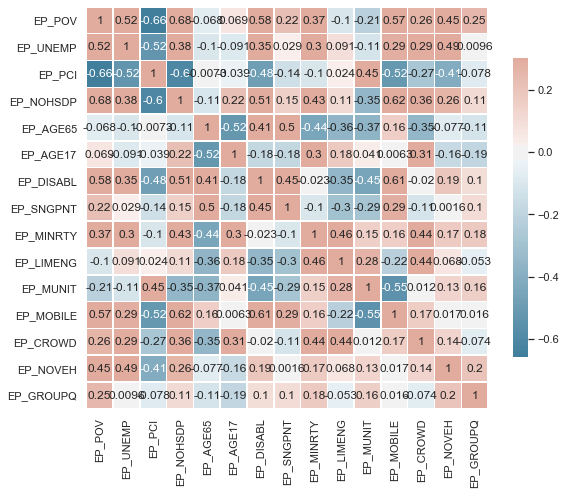

In [771]:
#plt.subplots(figsize=(10, 10))
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)
from scipy import stats
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix


corr = Ready.corr(method ='spearman')
p_values = corr_sig(Ready)

mask = np.invert(np.tril(p_values < 0.05))

#print (mask)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 11))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(corr, annot=True, cmap=cmap, vmax=.3, center=0, 
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#sns.heatmap(corr, mask = mask , annot=True, cmap="RdYlGn")
#plt.show()

# SVI calculation 

We calculate the ratio of county value to state value by population for each SVI variables (we use EP-estimate percentage- values in the CDC data set), then we take the average of all 15 SVI variables. 

Let SVI variable set be K, where  

K = { Below Poverty, Unemployed, Income, No High School Diploma, Aged 65 or Older, Aged 17 or Younger, Civilian with a Disability, Single-Parent Households, Minority, Speaks English “Less than Well”, Multi-Unit Structures, Mobile Homes, Crowding, No Vehicle, Group Quarters }

We will use these variables in a county base and state base. While County base values are exactly same as the estimated values for these variables in the CDC website, to calculate the state base, we simply sum the county values for all of the counties in each state for each variable. Then we use the following formula to calculate the SVI value for each county.

Let $S$ is the set of states and $j$ is a county in the state $s$, where $s \in S$, $c^k_j$ SVI variable $k \in K$ value for county j, and $c_s$ SVI variable value for state s.

$SVI_j = \frac{1}{15}\sum_{k \in K} \frac{c^k_j}{c^k_s}$


In [772]:

from collections import Counter
# Sum all SVI variable values for each county
#SVI_county_sum = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_MINRTY_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))
SVI_county_sum = dict(Counter(E_POV) + Counter(E_UNEMP) + Counter(E_PCI) + Counter(E_NOHSDP) + Counter(E_AGE65) + Counter(E_AGE17) + Counter(E_DISABL) + Counter(E_SNGPNT) + Counter(E_MINRTY) + Counter(E_LIMENG) + Counter(E_MUNIT) + Counter(E_MOBILE) + Counter(E_CROWD) + Counter(E_NOVEH) + Counter(E_GROUPQ))

# Divide the sum of all SVI variable values
SVI_county = {j: (SVI_county_sum[j]/(15*100)) for j in SVI_county_sum }


In [773]:
for i in SVI_county:
    print (i, E_POV[i], E_UNEMP[i], E_PCI[i], E_NOHSDP[i], E_AGE65[i], E_AGE17[i], E_DISABL[i], E_SNGPNT[i], E_MINRTY[i], E_LIMENG[i] , E_MUNIT[i], E_MOBILE[i] , E_CROWD[i], E_NOVEH[i] , E_GROUPQ[i])


1063 38.1 11.5 14.884 20.8 21.3 22.63334935 24.7 11.2843104 82.76069198 0.051639555999999996 5.8489827860000005 35.8 2.168756354 18.0 0.816914945
1005 30.7 9.2 18.473 26.8 18.6 20.925831 21.4 4.751203852 54.18950357 1.8907213059999999 1.731457588 29.3 3.852327448 10.2 11.37967746
1107 22.7 10.3 23.024 18.5 18.5 19.91305637 25.1 7.0053686 46.35182532 1.678307099 1.6478932000000002 25.2 1.309414692 10.3 9.035222052
1131 30.1 15.3 16.841 23.5 19.0 24.12695441 19.2 5.65646082 73.15794401 0.649350649 0.13848018 40.4 1.401141671 15.6 2.349967232
1105 30.8 10.1 15.055 17.2 19.1 21.59690089 22.1 7.328990227999999 70.65533197 0.0 2.280405405 24.3 0.0 13.0 8.716238029
1065 24.2 10.9 21.191 16.0 18.8 23.32365453 21.2 5.150442478 60.46998447 0.209764919 1.398870637 37.4 3.89380531 10.0 1.370788034
1119 31.8 9.7 16.799 13.3 17.5 19.30139877 23.0 5.786236063 75.18949754 0.546267174 3.463329453 32.5 0.422914264 10.9 6.876611706
1123 18.9 9.9 25.217 19.3 21.0 20.88996325 19.8 6.084541807999999 31.1265

5129 21.9 3.8 20.41 18.2 25.3 20.13151239 20.6 6.582506763 6.86646434 0.252491694 1.235818476 20.1 0.9618274720000001 9.0 1.0748608999999998
5111 21.4 5.8 20.963 19.7 17.8 23.82407097 22.3 3.957589754 13.19049213 0.143080706 1.082014912 12.4 3.0547973969999997 6.0 1.473049883
5075 15.6 7.2 21.473 15.9 19.3 22.53308357 23.4 4.471607613 4.737446371 0.076873799 3.6602123669999997 12.1 1.748414049 4.7 3.3174209919999997
5015 14.8 3.7 25.295 13.7 22.6 21.75934203 15.1 6.266271658 20.37904524 4.305639782 2.142388691 15.8 5.952060329 5.2 1.0084033609999998
5055 16.4 7.6 23.494 11.8 15.7 24.52544674 22.9 5.424829025 7.000912388 0.233205625 2.746356605 13.5 2.509563 5.2 1.57331375
5031 16.6 6.2 26.948 10.7 13.5 24.92524105 17.6 4.609063443999999 23.96851274 0.68282622 8.856494836 6.5 2.7359516619999997 6.9 3.557687829
5079 20.0 2.3 14.764 18.9 15.1 15.10219249 21.1 3.684071031 35.80081754 0.9997674959999999 0.385239254 33.7 3.074476544 6.3 37.84466741
5025 18.4 5.5 24.225 10.4 20.5 22.24409449 

10005 11.3 4.3 35.491 11.9 27.0 18.84002424 14.0 5.067777572 25.03921848 2.461430081 4.678578407 15.2 2.381757309 3.9 1.3410047059999999
10003 11.4 5.9 37.532 8.4 15.2 21.69302275 11.3 4.679612688 42.55967204 2.104857245 14.17412064 2.1 1.3734702109999999 6.7 3.038306977
11001 16.2 6.9 56.147 9.1 12.1 17.89130093 11.7 4.861702053 63.42150739 2.443475804 46.56350737 0.1 3.625705907 35.9 5.647460671
12107 23.6 8.7 20.915 18.2 22.7 21.44651341 16.9 8.309435788 28.51253208 2.630588372 2.413470533 43.2 2.228518122 7.3 1.896193961
12051 25.3 7.4 19.167 33.7 13.1 26.96160267 12.0 5.667757643 67.96130806 15.95324551 1.5536341530000002 40.1 7.974774487 8.2 4.929784936
12039 22.8 7.1 20.734 20.2 17.3 21.85874415 19.4 5.942037437000001 67.68092284 2.7450799010000004 1.118612329 29.3 3.312146481 10.1 8.272935031
12043 17.4 12.0 21.953 25.5 26.9 15.38916839 18.2 13.19148936 40.2559929 6.127750611000001 0.382653061 50.6 3.0851063830000003 4.9 10.49126961
12047 29.9 11.7 16.136 27.0 17.0 19.07022197 

13031 26.4 8.0 22.328 12.7 11.1 19.98949028 13.3 4.266666667 36.51734104 0.484706669 8.414967079 18.1 2.023744292 5.0 10.94850236
13023 18.0 6.2 20.458 11.4 17.7 21.28523464 16.1 5.459770115 31.43593347 0.389944412 1.7095622769999999 24.5 1.269157088 4.8 11.75138596
13123 16.8 4.2 27.282 18.3 24.1 19.537055300000002 20.8 5.2075534480000005 14.131649900000001 3.616674187 1.3601868069999998 20.8 2.503951418 4.7 0.7989741570000001
13241 18.1 4.2 28.266 15.2 27.5 16.55151697 21.2 5.493845692000001 12.29798738 1.055873295 1.741884402 11.7 2.461723206 4.8 2.655452088
13229 22.1 6.5 22.268 16.6 16.8 25.02857143 15.6 5.320658343 15.96883117 0.73938181 0.612219909 35.6 1.631668558 4.3 0.924675325
13265 21.1 7.3 21.416 29.0 25.2 14.95965239 21.4 3.70994941 67.22532588 0.0 0.39215686299999997 40.5 1.1804384490000002 13.8 0.24829298600000002
13045 17.3 7.1 24.993 15.4 13.4 23.90449127 14.4 3.975848985 29.749195699999998 1.575850322 4.912504959 10.9 2.145431115 4.7 2.917658705
13125 18.9 1.9 23.541

17117 13.9 6.6 28.809 8.7 19.6 21.29863845 14.7 5.345695364 3.9438664410000004 0.22468786899999998 1.6238844419999998 8.2 1.112582781 4.1 1.979631788
17097 7.9 5.2 45.766 9.4 13.7 24.45511089 9.1 3.937478161 38.36384294 4.7791213280000004 11.66056998 1.7 2.289514956 5.0 2.59382756
17073 10.8 4.5 30.345 8.8 20.3 22.36182434 12.8 6.632755842000001 9.564211338 0.749522153 3.713061132 1.7 0.735294118 5.2 1.4451864330000002
17061 13.1 2.5 25.414 9.4 19.1 20.78129759 15.6 6.506364922 3.7846481880000002 0.088240013 0.139794967 9.7 1.17195393 4.0 2.155041121
17027 7.7 2.6 31.783 9.9 16.6 21.18297284 14.3 5.664321048 8.561407238 0.35170648 2.411535071 10.0 1.6233540030000002 4.6 5.965350481000001
17035 13.9 3.0 27.812 9.4 19.3 22.89590255 16.4 5.024424285 3.3314876339999997 0.128053586 0.779967159 11.2 1.7213305419999998 3.3 1.1535621999999999
17023 11.1 5.5 30.796 7.2 19.3 23.05293968 17.1 3.973214286 3.474166455 0.283534733 1.484514973 10.4 1.383928571 3.4 1.342580809
17131 9.6 4.4 29.268 8.1

19163 12.1 3.8 33.643 7.2 15.8 23.860802800000002 10.9 5.181957894 20.02655904 1.246351123 11.30913892 2.2 1.186195372 6.6 1.9432170069999999
19099 9.0 3.8 28.604 6.1 18.9 22.38240783 13.1 5.022643063 6.542966109 0.264322243 7.571481163 4.1 1.523260601 5.3 4.744259014
19143 12.5 2.9 30.955 11.6 21.0 23.39722406 12.1 4.291682491 10.90548579 2.372166579 1.691474966 1.0 1.595138625 5.4 1.470588235
19091 13.0 4.1 30.48 7.2 20.8 23.30960854 14.7 4.863440345 6.573163073 1.224535233 2.487352445 2.6 0.694777192 6.1 1.2560184220000001
19157 9.9 4.0 31.827 6.1 20.2 19.55623233 9.7 6.694991631000001 8.353273874 0.58894162 5.047076856 4.3 0.8368739540000001 5.1 9.125516641
19189 9.0 3.4 28.342 7.6 20.9 21.70115815 13.4 5.5931833079999995 8.534269983 0.973016351 3.75 0.3 0.808389775 4.0 5.9711410670000005
19061 11.4 3.9 32.905 7.3 17.3 22.89393908 11.2 4.760533892 9.251201254 0.669131889 8.523208794 3.7 1.080868882 5.9 4.272957868
19167 6.3 2.7 29.36 9.8 15.2 27.08243604 8.8 3.51077727 13.09903236 

21175 22.7 6.3 18.31 23.7 16.5 18.633353399999997 26.1 7.009249743 7.337447321 0.015807777 2.164066432 32.9 2.548818088 6.2 12.33443709
21071 30.7 11.3 19.471 24.8 17.5 21.59863946 28.2 4.44 2.967961378 0.195449242 2.302080519 30.0 2.126666667 9.0 2.350779021
21121 33.2 7.2 17.832 26.5 17.1 23.36681014 17.1 5.660061868 4.234018811 0.129445429 2.944369064 31.5 1.3962043309999999 11.5 2.31468197
21041 24.1 7.9 25.217 21.7 15.1 25.78015181 15.9 5.096317971 11.34851467 1.103350542 0.827147402 21.1 4.706169227 8.8 3.017524131
21233 23.0 4.9 22.911 17.5 17.4 23.17110499 24.5 6.6424389260000005 11.63911846 0.944317812 1.728187919 20.2 2.44296386 6.1 3.129782675
21065 30.9 11.0 17.746 24.4 18.6 21.62542182 26.3 6.237497727 0.977221597 0.014883167 1.905586834 20.4 2.527732315 7.7 0.8998875140000001
21155 23.0 8.9 22.241 18.5 16.5 24.34525047 20.5 5.293720458999999 12.21679485 0.17130857600000002 1.6369764080000002 13.0 2.849426063 7.9 4.557264602
21031 19.3 5.7 22.951 20.4 18.1 22.64963961 21.7

22023 9.9 4.7 28.358 15.3 16.0 22.64069264 14.2 4.389173372 11.71717172 2.606562404 0.12121212099999999 37.6 3.8405267010000004 1.1 0.40404040399999996
22103 11.5 5.5 34.658 9.5 16.4 24.08418412 15.0 4.641681547 21.43716564 1.68527614 6.259899523 7.4 1.611411114 3.5 0.896709843
22005 10.6 5.7 34.168 11.4 11.4 26.992868400000003 12.2 4.064417178 31.58129863 1.231027488 2.0130404509999997 19.0 2.170477784 3.6 0.716409182
22089 11.2 5.5 32.935 10.0 13.0 24.63570386 11.8 4.8979804289999995 34.87957857 0.44023506100000004 1.61757605 9.4 1.96231522 4.0 1.114206128
23025 20.4 6.6 24.386 11.6 20.7 19.27355503 21.7 6.674171005 4.297307997 0.377852056 2.300116626 14.3 2.621828244 9.0 1.494457641
23003 16.1 5.0 25.477 11.4 23.4 18.40906074 22.3 7.385824637000001 5.875326284 0.738522644 4.559575108 9.7 1.409405068 8.6 3.52903007
23029 18.9 7.0 25.157 10.7 23.8 19.03083421 22.5 7.17134363 10.561747800000001 0.490065342 1.789077213 11.7 0.91363933 8.9 3.1405798480000002
23021 18.5 6.3 24.074 9.7 25.

27021 13.6 5.0 30.326 7.8 25.3 21.13912806 14.8 6.859617138 17.09717097 0.148448532 1.7861285080000002 9.3 2.590398055 4.9 1.3393467270000001
27091 13.7 4.0 31.066 6.8 22.9 21.80636712 14.6 7.272519694 7.082409833 0.564460301 8.305780984 2.5 1.221600639 5.3 1.601853718
27111 9.3 3.1 32.059 7.9 23.3 21.71148724 13.3 6.153036011 7.431909957999999 1.03847277 5.915508524 7.6 1.600032406 5.9 1.9658046219999998
27145 12.9 4.5 30.994 8.3 14.6 23.13508192 10.7 4.051850233 13.98089011 1.912894501 17.96981319 2.3 3.117066528 5.2 4.865195769
27113 11.0 2.8 31.159 6.8 17.9 23.35895086 12.7 6.171809842 9.335119509 0.55098498 12.48853562 11.2 1.2176814009999999 8.0 1.868434041
27077 10.7 3.6 25.64 7.0 23.5 21.18801379 12.9 12.58503401 7.02731371 0.11232799800000001 3.31056227 29.9 1.7006802719999998 2.9 1.378944577
27151 12.5 2.4 31.765 9.4 21.8 22.57719842 13.2 6.310110251 8.815044342 1.337110482 8.052859798 3.2 1.196340605 5.7 1.592050433
27125 10.5 2.9 30.037 7.4 20.0 24.53300125 14.1 8.268424206

29125 17.0 6.0 26.226 13.5 21.3 20.14086107 17.9 6.140350877 4.543905487 1.251042535 0.803300043 14.1 3.482190324 8.6 1.135976372
29179 19.4 5.5 22.72 20.2 22.7 19.85691574 25.9 6.086286595 6.26391097 0.0 0.544959128 18.0 1.8489984590000001 4.9 3.354531002
29083 21.1 6.0 26.944 12.2 21.4 22.10259949 19.7 6.560891937999999 6.478030826 0.38078500299999996 2.308394161 11.8 2.4549742709999998 6.1 1.2376351509999999
29121 12.8 5.2 22.136 11.8 22.0 23.73182446 16.8 6.877673225 6.401736956000001 0.454386578 2.229174814 11.9 1.659538067 7.5 1.796170801
29167 16.5 3.8 22.773 11.6 17.8 23.11326698 16.1 6.4805327870000005 6.264961572000001 0.298567547 3.271200177 12.4 2.740778689 6.6 4.863298475
29149 23.8 3.5 18.398 16.9 23.2 22.73879966 26.6 7.4841139089999995 5.964121349 0.0 0.182448458 15.8 2.918333726 4.0 1.249178172
29185 17.1 3.8 22.52 15.5 27.2 19.5090715 21.9 8.456148828 5.506937033 0.0 0.8840169729999999 21.5 1.7637110409999999 5.6 3.041622199
29021 17.2 4.6 26.347 11.7 15.8 22.66222021

31055 12.0 4.0 35.307 9.4 12.6 25.73485998 10.6 4.594127331 30.59539757 3.727346737 18.25217465 1.0 2.024204236 7.1 2.303176679
31175 9.4 1.1 29.378 7.7 25.4 22.30147408 15.1 7.667560322000001 5.254398478 0.530839232 5.818497612000001 3.4 1.6085790880000002 4.9 1.735615787
31111 9.9 3.2 31.567 6.5 18.9 23.69055384 15.0 5.8831448570000004 12.27065196 0.542038063 8.463278181 8.3 1.110662359 6.1 2.234636872
31101 12.4 3.4 29.823 8.5 26.7 20.12890431 13.1 10.02060793 10.31234507 0.350694895 1.935719503 22.1 1.262235961 5.3 0.9419930590000001
31163 12.4 3.1 28.448 7.0 26.7 20.7385427 17.0 10.23391813 3.659742829 0.693962526 0.768442623 15.3 0.657894737 2.9 2.0112100230000003
31127 11.6 4.1 29.574 8.2 19.7 21.02394952 15.1 6.516627477 6.195324824 0.33404190699999997 5.08426164 3.8 1.242861942 3.9 7.715473971000001
31113 11.3 0.4 24.355 6.0 20.1 27.61596548 10.7 5.475504322999999 5.6094929879999995 3.699421965 3.4246575339999996 14.6 2.017291066 0.0 0.0
31039 6.9 2.9 29.765 11.6 21.7 24.59785

35051 26.7 10.9 25.344 16.0 35.5 15.80092467 26.1 14.34743474 35.30958209 1.784697171 4.313267095 40.0 2.01620162 7.3 2.393255371
35019 15.4 7.0 17.42 17.3 21.8 19.09028256 19.7 16.04046243 80.61107282 3.811163019 2.134831461 27.2 0.794797688 7.9 18.12543074
35017 24.0 7.1 25.59 12.5 26.6 20.15974556 19.9 8.083706016 54.19061043 1.0843833520000001 2.5346692319999997 29.5 2.8858324189999998 7.0 2.826267664
35035 22.1 7.6 23.17 16.6 17.0 23.35455191 18.6 5.754421596 51.14081377 6.261656477000001 1.80185856 27.3 2.225607176 6.6 5.636784251
35007 20.0 6.1 24.035 11.8 27.0 18.4418146 22.9 9.926533402 53.26265615 0.7427238970000001 5.523142746 17.2 2.391935759 7.2 4.569362262
35005 19.4 5.1 22.041 21.8 15.5 26.76992509 16.4 7.0133997589999995 61.12458553 5.478797859 4.79123135 13.4 3.388593025 5.2 3.341827336
35041 24.9 8.7 20.123 20.0 13.9 24.38585345 18.8 5.019078368 48.16814909 6.759681092999999 1.021366518 20.0 5.180510713 4.7 5.940279543
35013 26.4 7.7 22.154 20.6 15.3 24.8133698 14.1 4

37059 13.9 3.9 31.173 12.2 20.2 21.33374352 16.5 6.370009144 15.590316399999999 2.064933449 3.0768410389999996 18.3 2.170070101 2.7 0.8306316109999999
37087 13.4 4.3 30.49 12.0 24.3 18.26118291 18.4 6.021836191 7.3837485460000005 0.715036441 1.7288956469999999 17.7 1.999774885 5.1 0.794391758
37189 25.3 7.4 26.882 9.2 15.5 13.02139281 11.0 4.13246667 8.31679563 0.455898421 10.84412314 8.5 1.7222564880000002 4.8 10.92216659
37031 10.7 5.7 33.722 8.4 24.2 17.76603446 18.8 5.266341791 13.62241205 0.659078198 9.940460782 17.8 1.1359435390000001 4.4 1.634573621
37063 15.2 4.6 35.398 11.6 12.6 21.10675714 9.7 3.596579677 57.52770581 5.724905277 19.33117742 1.4 2.8343906060000004 7.9 4.740129807
37073 13.5 6.3 25.846 10.9 19.8 20.44509872 22.7 4.46313066 36.74229304 0.28862631899999996 0.0 30.9 2.0698576969999998 4.7 0.424315899
37021 12.2 3.2 32.426 8.9 19.4 18.74605856 13.3 4.718130984 16.4551591 2.283649414 8.890182948 14.3 2.677732394 5.2 2.69730542
37125 11.3 4.8 34.606 9.3 23.8 21.34458

40107 26.3 7.5 18.437 20.5 17.5 23.04632469 19.1 5.809859155 38.70887545 0.12300123 0.0 17.8 3.571428571 8.5 11.42786111
40021 22.1 7.6 22.161 13.5 16.3 22.27313825 18.3 6.468646865 52.43301003 0.7995980159999999 4.558378842 20.5 2.622262226 6.2 3.974190367
40127 20.4 8.0 22.435 16.8 22.6 22.18727534 27.2 7.147643511 29.00790798 0.257363454 1.100501699 18.6 3.5961581419999997 8.3 0.952552121
40079 20.7 5.6 20.902 16.5 17.5 24.33934354 22.2 6.001861891 28.65509935 1.890217856 1.526682975 16.9 2.754504134 5.5 2.7145884139999996
40095 17.0 4.0 22.781 20.9 22.3 23.34444108 26.7 7.570621469 34.8985156 4.135048232 0.67114094 35.3 3.260694108 3.8 1.441987277
40069 20.9 7.9 21.197 14.0 19.1 23.65328995 23.1 8.132177174 30.47722343 0.40415704399999997 0.288628055 20.0 4.593391141000001 4.5 2.539768619
40135 21.5 7.2 20.384 18.7 18.1 23.70231844 22.3 6.294429365 37.54105828 0.458316264 1.353102805 21.4 4.478480031 5.4 0.9494353740000001
40141 19.8 3.6 21.974 22.5 19.6 23.70160529 20.8 6.30566441

45069 26.4 12.0 17.456 22.8 17.4 20.60329683 20.6 6.283158222999999 60.91653273 0.7693825209999999 0.995933272 29.5 3.037553313 13.2 10.45116436
45011 28.1 5.7 20.297 20.2 17.7 24.13098473 24.0 5.921052632 49.61116837 0.554445554 4.189176381 33.0 4.258373206 12.4 1.4850557480000002
45089 26.4 6.6 18.257 19.9 20.0 21.15949432 19.0 4.903042724 68.76197165 0.441136853 1.2726098190000001 39.8 2.916600977 12.3 5.018516153999999
45033 32.6 6.9 17.605 24.7 15.9 25.442340899999998 18.3 5.14099193 54.40711656 0.859749065 0.624682211 34.4 3.436394959 12.1 1.290364626
45009 23.4 4.4 18.479 19.7 21.0 20.1099054 19.8 7.3303337079999995 64.03032832 0.20424538600000003 1.206695212 29.2 2.3247094109999997 13.9 7.6099053979999995
45049 20.5 9.9 18.424 19.0 18.0 21.62134533 14.9 8.851708852 59.10856676 1.784941584 0.7515521190000001 37.3 1.53010153 6.8 6.885095073
45025 20.7 9.3 21.325 23.3 17.9 22.19659217 17.5 4.340782123 39.70578635 1.400069196 0.253748558 36.2 4.318435753999999 9.0 1.712619415
45031

47035 13.8 5.4 25.832 14.2 30.2 17.755336399999997 22.0 6.774931204 5.572818157 0.327857231 2.086558525 16.1 1.600713151 4.5 1.247973521
47041 18.4 5.0 25.399 19.9 18.1 21.82697637 17.4 5.334890966000001 12.01189097 0.117552765 0.841820827 16.1 2.9075804780000003 5.1 1.632488537
47111 17.3 3.2 22.527 19.7 15.7 24.30584682 19.6 4.220283533 8.132706987999999 1.096817874 1.4121288330000001 25.2 1.744820065 3.6 1.631574532
47113 18.5 4.9 26.722 11.1 16.4 22.56389245 14.3 5.402698714 44.24583867 1.0963690959999999 3.960671552 5.4 1.328273245 8.0 3.976440461
47031 14.0 4.5 26.557 14.6 17.2 23.96529551 17.4 6.208999352999999 11.62310493 0.40228995799999995 3.435812214 12.7 2.457728911 3.8 1.347606369
47155 13.7 4.7 25.283 15.0 19.3 20.49594099 18.2 4.006987369 10.01462892 2.019949038 9.187796042999999 11.9 2.786885246 3.1 1.184736473
47103 14.7 4.0 26.965 16.5 18.9 22.36469756 19.0 4.288455861 13.17061667 0.5422249920000001 1.383081377 15.5 2.612931798 7.8 1.0494045509999999
47023 15.8 7.6 22

48461 14.1 5.2 25.447 24.4 16.7 26.18201694 8.9 4.57957958 60.86362394 10.35294118 1.126927639 13.3 2.402402402 9.1 1.694452036
48075 13.9 8.1 21.233 18.0 13.8 17.73059424 18.7 4.8192771080000005 41.54143113 2.747015677 4.501718213 9.6 0.457000415 5.7 20.76382187
48387 19.7 6.5 22.689 14.6 24.4 20.05587051 18.5 5.682047149 26.61243941 0.146135992 3.107466552 16.5 0.564174894 5.6 1.618601594
48029 15.7 5.3 27.834 15.8 11.8 25.72490466 14.1 4.309031898 72.32568107 5.927686982000001 16.74126649 2.6 4.193824706 7.2 1.564795531
48459 16.0 5.3 25.285 14.2 17.9 23.92608123 17.8 5.365749929 19.61821639 1.089318982 0.7739665790000001 20.2 3.700028353 4.4 1.338436784
48265 11.7 5.2 32.988 11.4 27.1 19.292865 17.9 5.947764332 31.27905407 2.075582932 3.8358499760000004 18.3 3.462131477 3.1 3.331211543
48325 11.3 3.4 27.475 16.8 16.5 23.16758895 17.1 5.5413850270000005 56.43366562 2.115560082 1.238273921 25.9 3.577349828 4.9 4.992308768
48181 13.1 4.6 28.011 11.3 17.5 23.73792114 17.0 5.815825319 2

50011 8.6 3.7 31.195 9.3 15.6 22.31248473 13.2 5.861121586 6.122241225 0.24045231 3.7230741960000002 7.3 1.993212304 5.8 0.855118495
50015 13.6 3.7 36.747 7.2 16.7 20.40840509 12.2 5.784183577 5.478315822999999 0.070744902 2.222059791 9.3 1.593021051 4.4 2.543644838
50001 7.2 3.9 34.741 6.5 19.2 17.19266851 14.8 5.183763028 7.453500352000001 0.34790971299999995 2.208708623 7.4 0.891387822 4.2 8.215389621
50013 7.5 4.2 39.77 7.1 20.0 17.57334093 10.6 4.972936401 7.191683281 0.223214286 0.529300567 11.9 0.40595399200000004 2.8 0.0
51640 23.8 7.3 23.025 24.3 22.4 21.69709989 26.2 9.12504694 20.91453123 2.247372676 6.101593027000001 8.7 1.840030041 15.6 5.708147921
51595 27.0 23.4 18.494 20.6 16.8 28.73943403 17.0 7.526366251000001 75.54208012 0.947775629 8.134171907999999 2.5 1.294343241 21.2 4.4652701210000005
51105 25.5 9.1 19.72 23.3 20.8 18.46500752 26.0 7.651109411 7.102889594 0.37181225700000003 1.76301068 22.8 0.666739534 11.3 6.217638216
51720 28.2 10.6 21.741 16.0 16.4 23.7027707

53023 10.3 7.0 26.742 5.6 24.7 23.99103139 19.8 11.48373984 10.53811659 0.0 0.884955752 15.8 1.0162601629999999 2.7 0.986547085
53037 18.0 5.6 29.161 8.6 15.7 17.21463276 12.8 6.088188805 15.91825174 0.7312948490000001 9.734885089 7.3 1.487981686 4.1 5.523236813
53069 7.3 7.5 31.11 7.9 33.0 16.42455483 22.6 8.381655245 13.26148079 0.658536585 1.768264309 14.2 1.265155509 1.1 1.194939082
53053 10.4 5.3 34.618 8.5 13.5 23.5018181 13.3 4.326685143 33.24181055 2.374753037 11.88685444 5.7 2.814448679 5.2 2.210229495
53043 12.5 3.6 28.891 7.3 25.5 21.40155097 19.4 6.917127072 8.672214867000001 0.318661621 0.809917355 19.6 1.767955801 1.6 1.21997352
53029 7.8 5.6 37.087 4.7 24.0 18.27770135 15.4 5.292222734 20.8420824 0.710842911 3.2671471530000002 7.9 1.791877589 3.3 3.054328675
53011 9.3 4.8 35.86 7.3 15.0 24.27924235 12.3 4.672479832 21.51116107 2.582533892 10.95971369 4.5 3.048763032 4.5 0.877122548
53035 8.7 4.6 37.493 5.2 17.4 20.55423082 14.9 5.223600512 23.31222121 0.567199805 9.72326

72019 0.0 18.1 8.537 0.0 15.1 0.0 0.0 0.0 0.0 77.764934 1.367060355 0.7 4.575688073 14.0 0.0
72021 0.0 12.7 14.782 0.0 21.0 0.0 0.0 0.0 0.0 52.87198772 8.272438825 0.4 2.074811785 13.2 0.0
72023 0.0 14.8 9.903 0.0 22.5 0.0 0.0 0.0 0.0 59.26361982 5.81851376 4.4 3.968202676 13.6 0.0
72025 0.0 13.2 15.244 0.0 19.6 0.0 0.0 0.0 0.0 59.98544514 5.496854472000001 0.1 2.457247219 15.9 0.0
72027 0.0 12.6 10.709 0.0 19.2 0.0 0.0 0.0 0.0 67.19064759999999 0.8128357359999999 0.3 1.553449184 11.6 0.0
72029 0.0 23.5 12.924 0.0 16.4 0.0 0.0 0.0 0.0 61.903885100000004 1.83678083 0.1 5.606774568 12.7 0.0
72031 0.0 14.8 16.846 0.0 21.7 0.0 0.0 0.0 0.0 49.14138776 21.72213637 0.3 2.309841865 13.0 0.0
72033 0.0 21.0 12.796 0.0 19.0 0.0 0.0 0.0 0.0 66.66090937 11.35371179 0.2 3.4229267169999997 26.2 0.0
72035 0.0 9.3 12.819 0.0 19.9 0.0 0.0 0.0 0.0 62.30078376 2.8335832080000003 0.4 1.893542219 16.5 0.0
72037 0.0 12.7 11.204 0.0 22.8 0.0 0.0 0.0 0.0 61.08896539 3.552133982 0.5 3.5511363639999995 18.0 0.0


In [774]:
SVI_county

{1063: 0.207099096914,
 1005: 0.17559581481599998,
 1107: 0.16037672488866667,
 1131: 0.19161419931466667,
 1105: 0.1748219110146667,
 1065: 0.1703388735853333,
 1119: 0.1780568366466667,
 1123: 0.137841415424,
 1085: 0.18735402760733333,
 1047: 0.169497026434,
 1121: 0.14319177790666665,
 1087: 0.17872904437133336,
 1059: 0.125768671182,
 1023: 0.15853125943466664,
 1093: 0.12033023037533333,
 1025: 0.15219421757733337,
 1133: 0.12278787863000003,
 1113: 0.14405129364600003,
 1021: 0.13117241429733337,
 1053: 0.13848775682266667,
 1127: 0.1268560676406667,
 1075: 0.12255488052066667,
 1039: 0.12404055332933335,
 1017: 0.13701183775599998,
 1061: 0.12875359690466667,
 1057: 0.12498621399933332,
 1109: 0.14071098335999999,
 1091: 0.160247751888,
 1007: 0.13439262602333332,
 1049: 0.12641562878599996,
 1011: 0.18141923749866665,
 1015: 0.12586876751,
 1111: 0.12944471574866664,
 1045: 0.1275598260766667,
 1101: 0.147415883336,
 1035: 0.14734283098466666,
 1129: 0.14316664768466666,
 1013

In [775]:
# Sum all SVI variable values for each county
#

#SVI_county_sum_no_race = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))


SVI_county_sum_no_race = dict(Counter(E_POV) + Counter(E_UNEMP) + Counter(E_PCI) + Counter(E_NOHSDP) + Counter(E_AGE65) + Counter(E_AGE17) + Counter(E_DISABL) + Counter(E_SNGPNT) + Counter(E_LIMENG) + Counter(E_MUNIT) + Counter(E_MOBILE) + Counter(E_CROWD) + Counter(E_NOVEH) + Counter(E_GROUPQ))


# Divide the sum of all SVI variable values
SVI_county_no_race = {j: (SVI_county_sum_no_race[j]/(14*100)) for j in SVI_county_sum }


# Proportional Allocation

We consider allocating 1 million CHW over the states proportional to Medicaid enrollment in each state. Further, we allocate CHW to counties in each state proportional to different county vulnerability criterias as follow.

- MEDICAID
- SVI
- YPLL
- UNEMPLOYMENT
- LAST 14 DAYS COVID CASES
- LAST 14 DAYS COVID CASES / POP
- COVID DEATHS / POP

To calculate the total number of allocated CHW to per county according to these vulnerability criterias, we define the following function called "Proportional_allocation", in which we multiply the CHW allocated to each state with the ratio of the chosen vulnerability criteria of the county to the chosen vulnerability criteria of the state, the function return a dictionary with the counties as keys and the number of CHW allocated to each county for the chosen vulnerability criteria as values. 

In [776]:
def Proportional_allocation(county_level, state_level, state_budget):
    prop_allocate = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j],state_level[s], state_budget[s])
            prop_allocate[j,s] = (float(county_level[j])/float(state_level[s]))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [777]:
def total_state_pop(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]*Firstphase_county[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [778]:
def Proportional_allocation_pop(county_level, state_budget):
    prop_allocate = {}
    state_level = total_state_pop(county_level)
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j], Firstphase_county[j], state_level[s], (county_level[j]/state_level[s]), state_budget[s], ((float(county_level[j])*Firstphase_county[j])/(float(state_level[s])))*float(state_budget[s]) )
        
            prop_allocate[j,s] = ((float(county_level[j])*Firstphase_county[j])/(float(state_level[s])))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [779]:
# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

In [780]:
# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)

In [781]:
#print ('Med', Medicaid_demand[35039])
#print ('Med', Medicaid_demand[4017], 'Pop', population_county[4017], 'Med_capita', 100000*(Medicaid_demand[4017]/population_county[4017]))

In [782]:
# Dictionaries for the different vulnerability criteria values for states

# Dictionary for total Medicaid patient numbers for each state
# Medicaid_demand_state = total_state(Medicaid_demand) 

# Dictionary for total positive COVID cases for last 14 days in each state
#Covid_state = total_state(COVID_14days) 

# Dictionary for total SVI values for each state
SVI_State = total_state(SVI_county) 


# Dictionary for total SVI values for each state
SVI_State_no_race = total_state(SVI_county_no_race) 

# Dictionary for total YPLL values for each state
#YPLL_state = total_state(YPLL) 

 

In [783]:
for j in location:
    print (j , SVI_county[j], SVI_county_no_race[j], E_MINRTY[j])

1063 0.207099096914 0.16277710956500002 82.76069198
1005 0.17559581481599998 0.14943158475285714 54.18950357
1107 0.16037672488866667 0.13872375858071426 46.35182532
1131 0.19161419931466667 0.15304525354428572 73.15794401
1105 0.1748219110146667 0.13684109610857145 70.65533197
1065 0.1703388735853333 0.1393130899342857 60.46998447
1119 0.1780568366466667 0.13706839816428573 75.18949754
1123 0.137841415424 0.12545400659714287 31.126513899999996
1085 0.18735402760733333 0.14691876081500002 75.34477627
1047 0.169497026434 0.12968692197214285 72.68384889
1121 0.14319177790666665 0.12672479182142854 37.37295831
1087 0.17872904437133336 0.13139124756214288 84.14581997
1059 0.125768671182 0.11821502372357143 23.15197356
1023 0.15853125943466664 0.13869714242999998 43.62088975
1093 0.12033023037533333 0.12310639883357143 8.146387196000001
1025 0.15219421757733337 0.1292929708971429 47.28116711
1133 0.12278787863000003 0.1270566154321429 6.30255634
1113 0.14405129364600003 0.11581617858500003 

17163 0.12077046390933331 0.10199361930285715 38.36462884
17103 0.10459544979533333 0.10220251875928572 13.80964843
17195 0.10033603906333334 0.09648308833214286 15.42773493
17167 0.11043809531066666 0.10428217596857142 19.66209661
17045 0.093327785844 0.0986809556207143 1.838340897
17047 0.09886711893533334 0.10341716046142857 3.516653757
17065 0.10260870039333334 0.10901183792500001 1.296477495
17011 0.09846078007600001 0.09670583506000004 12.30300103
17037 0.10751422546 0.09863190585714286 23.18666999
17015 0.09593626949333331 0.09784129840071425 6.926586479
17125 0.09734600981666668 0.10176644254999999 3.545995155
17001 0.09692737339133331 0.0979103557742857 8.316562003
17053 0.09473583628333336 0.09685201965857142 6.510926903
17107 0.102832233226 0.10043948385642856 13.63307244
17067 0.09276978609466668 0.09664757171500002 3.848078741
17089 0.12336294899533334 0.10149803203071428 42.94717865
17119 0.10032833708600002 0.09683199510642859 14.92771248
17013 0.09861558286266665 0.1035

27137 0.10178083134466667 0.10270502967785715 8.884205468
27047 0.10393659410600001 0.10068257744214287 14.94928274
27021 0.10799082532666666 0.10349219072857145 17.09717097
27091 0.09914732819266667 0.10117041604 7.082409833
27111 0.09885016768733332 0.10060238683785715 7.431909957999999
27145 0.10568452816733334 0.10324707295785714 13.98089011
27113 0.1043670108353333 0.10515385481714284 9.335119509
27077 0.10896191775133333 0.11172540208357144 7.02731371
27151 0.0998971428873333 0.10073619284928569 8.815044342
27125 0.09999806110266667 0.10146563298214285 7.945205479
27011 0.09583850693733333 0.09986757563000001 3.9431545239999997
27131 0.10822855042666665 0.10327178056428571 17.76233285
27173 0.09597807400266667 0.09531523678857143 10.5257795
27097 0.09358773240266667 0.09718332360285714 4.32494556
27045 0.09082861282066669 0.09465685082071429 3.723328082
27161 0.09598749245133335 0.09514439749785715 10.77908218
27065 0.09802531471266665 0.10132894402642856 5.177450432
27005 0.1034

38093 0.10509665932599999 0.10699557746428572 7.851180539
38105 0.127785336384 0.12229564678999998 20.46409907
38025 0.11453551121533334 0.110901244545 16.54152446
38039 0.10172427171466672 0.10563976037500004 4.690743047
38057 0.10228495386066667 0.10347122593071431 8.567714488
38035 0.11543321464266669 0.1120452622814286 16.28645477
38103 0.10084315902133333 0.10538743180571428 3.722334004
38077 0.10255193862933332 0.1036412494385714 8.73015873
38003 0.10292400716933332 0.10493158917142856 7.481785914
38089 0.106947985724 0.10554393626857142 12.66046781
38029 0.10212513837733334 0.10620442642285714 4.501510574
38069 0.09538667438133333 0.09754312854857143 6.519631604
38073 0.09599347851133334 0.09872358960357144 5.777192322
38063 0.09523250263266665 0.09867812566142853 4.699378023
38021 0.09124200152133333 0.09294241527357142 6.743620899
38007 0.100742842538 0.1058470338007143 2.928416486
38101 0.10675541439799999 0.10207397758357142 17.22955298
38065 0.10205558409133332 0.1023652779

48159 0.11228724544666668 0.10507020098571429 21.33258679
48137 0.163328232532 0.13447613771285716 56.725756000000004
48089 0.13760316853533333 0.11595479758071428 44.06803619
48357 0.150679790178 0.12080357540500002 56.894679700000005
48475 0.14530588693066668 0.11282651059714287 60.00171556
48135 0.15744242526933333 0.12032582454571428 67.70748354
48433 0.12102338848400003 0.11243988681142861 24.11924119
48369 0.15901257863066667 0.12330038211142857 65.89833299
48467 0.11802530946466668 0.11482033569785716 16.28949422
48069 0.15084715713933333 0.11301924699928571 68.04378991
48287 0.12813354441733335 0.11109797669 36.66314926
48451 0.13386553676000001 0.11004930870000001 46.72927296
48169 0.17511817547733335 0.14452235675428574 60.34596376
48105 0.141209753168 0.10660205225142856 62.5717566
48379 0.11786841867933336 0.11580945832071429 14.66938637
48413 0.14482903712266665 0.11669401048857142 53.87194100000001
48303 0.1324528293466667 0.10867994421428573 46.52732212
48175 0.135012416

In [784]:
for s in State:
    print (s, SVI_State[s], SVI_State_no_race[s])

Alabama 9.128653540462665 8.097928673622143
Alaska 4.409220932543333 3.6443374272607145
Arizona 2.29297136842 1.923183378464286
Arkansas 9.564243790012664 8.918139728374284
California 8.253603888590668 6.926848028054286
Colorado 7.391158580642668 6.746413409899999
Connecticut 0.9091004893213331 0.8318899603942856
Delaware 0.3747054359966666 0.32575152982499994
District of Columbia 0.19506777341666662 0.16370010909642857
Florida 9.327382839130001 8.43290225861786
Georgia 21.939314047085343 19.195845214493573
Hawaii 0.7482525376346667 0.5382407809014286
Idaho 4.873932562604666 4.667633987263571
Illinois 10.733373305215334 10.53457743836071
Indiana 9.232008323621997 9.252086685849996
Iowa 9.474602586401334 9.501782869930716
Kansas 10.85557287960266 10.445168752252856
Kentucky 14.251261296138004 14.542283450922143
Louisiana 9.005227875452666 7.885200159656427
Maine 1.6037290898266665 1.6496491181385713
Maryland 2.895670873152 2.5419213884285714
Massachusetts 1.618015633624667 1.50894223661

# 1 million CHW allocation to states

We allocate 1 million CHWs to states proportional to total Medicaid enrolles in each state.

Let's $FedCHW$ represents the number of CHW will be allocated within states by the federal government, which is 1 million in our project. $TotMed$ represents the total Medicaid enrollee numbers over the US, $Med_s$ is the total Medicaid enrollee numbers in state $s \in S$, and $CHW_s$ is the total number of CHW allocated to state $ s\in S$. 

$CHW_s = FedCHW*\frac{Med_s}{TotMed}$



# Proportional allocation for different vulnerability values

Let V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}. We assume $v_j$ represent the vulnerability value for county $j \in J$, while $v_s$ represent the sum of the vulnerability values for each county in the state of county j.

$Prop_{v_j} = \frac{v_j}{v_s}*CHW_s$



In [785]:
Vaccine_budget_state

{'Alabama': 166725,
 'Alaska': 62400,
 'Arizona': 237900,
 'Arkansas': 104325,
 'California': 1323075,
 'Colorado': 189150,
 'Connecticut': 126750,
 'Delaware': 34125,
 'District of Columbia': 27300,
 'Florida': 724425,
 'Georgia': 343200,
 'Hawaii': 50700,
 'Idaho': 55575,
 'Illinois': 345150,
 'Indiana': 225225,
 'Iowa': 108225,
 'Kansas': 99450,
 'Kentucky': 154050,
 'Louisiana': 159900,
 'Maine': 49725,
 'Maryland': 205725,
 'Massachusetts': 242775,
 'Michigan': 343200,
 'Minnesota': 189150,
 'Mississippi': 100425,
 'Missouri': 209625,
 'Montana': 39000,
 'Nebraska': 66300,
 'Nevada': 100425,
 'New Hampshire': 49725,
 'New Jersey': 305175,
 'New Mexico': 72150,
 'New York': 683475,
 'North Carolina': 348075,
 'North Dakota': 27300,
 'Ohio': 398775,
 'Oklahoma': 132600,
 'Oregon': 143325,
 'Pennsylvania': 449475,
 'Rhode Island': 39000,
 'South Carolina': 172575,
 'South Dakota': 32175,
 'Tennessee': 228150,
 'Texas': 906750,
 'Utah': 94575,
 'Vermont': 25350,
 'Virginia': 289575,
 

In [786]:
# Calling proportional allocation function for different vulnerability criterias



# Proportional allocation according to SVI score in each county
Proportional_to_Adult_pop = Proportional_allocation(Adult_pop_county, Adult_pop_state, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_Firstphase = Proportional_allocation(Firstphase_county, Firstphase_State, Vaccine_budget_state)


# Proportional allocation according to SVI score in each county
Proportional_to_ADI = Proportional_allocation_pop(ADI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_PVI = Proportional_allocation_pop(PVI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)


In [787]:
for j in SVI_county:
    print(j, SVI_county[j], SVI_county_no_race[j])

1063 0.207099096914 0.16277710956500002
1005 0.17559581481599998 0.14943158475285714
1107 0.16037672488866667 0.13872375858071426
1131 0.19161419931466667 0.15304525354428572
1105 0.1748219110146667 0.13684109610857145
1065 0.1703388735853333 0.1393130899342857
1119 0.1780568366466667 0.13706839816428573
1123 0.137841415424 0.12545400659714287
1085 0.18735402760733333 0.14691876081500002
1047 0.169497026434 0.12968692197214285
1121 0.14319177790666665 0.12672479182142854
1087 0.17872904437133336 0.13139124756214288
1059 0.125768671182 0.11821502372357143
1023 0.15853125943466664 0.13869714242999998
1093 0.12033023037533333 0.12310639883357143
1025 0.15219421757733337 0.1292929708971429
1133 0.12278787863000003 0.1270566154321429
1113 0.14405129364600003 0.11581617858500003
1021 0.13117241429733337 0.12635019646857146
1053 0.13848775682266667 0.11997562070285714
1127 0.1268560676406667 0.12802230256500002
1075 0.12255488052066667 0.1213031418292857
1039 0.12404055332933335 0.12096510898

19165 0.08729996342 0.08964606134642857
19015 0.08846774480333335 0.09074548040785714
19055 0.085950935906 0.08964185521857142
19119 0.08164973575533334 0.08422462953571429
19161 0.08644235779000002 0.08895866635
19037 0.08360323261133333 0.08654574095857143
19149 0.09009866820866667 0.09061040033928572
19023 0.08452883645133334 0.08810557684928573
19093 0.08982523883200001 0.09291882747500001
19017 0.08375014472533333 0.08619878992214285
19181 0.090267406924 0.09257137727357143
19059 0.09596590853999996 0.09974693980857142
19191 0.08668906164666666 0.08931711192785714
19195 0.08628198753133336 0.08834827744000001
19121 0.08412063245133333 0.08678800498785713
19049 0.09822182066466664 0.09482586758357142
19095 0.08578722542466666 0.08833220478642857
19031 0.08097806424733334 0.0835810725207143
19009 0.08544503978333332 0.08909935058428571
19011 0.08198912274200001 0.08500907557214288
19075 0.08141995061666667 0.08504616861714286
20019 0.12219118154866665 0.12092385203071428
20209 0.148

32009 0.1420400557846667 0.13781160333357143
32017 0.11806424657333332 0.1171758405785714
32003 0.144561862586 0.1140124411207143
32001 0.11708151613733331 0.10631461518999999
32013 0.14477470694666664 0.13037807534999998
32033 0.12177251183466666 0.11017624407999999
32031 0.12869433689866663 0.11151204246285713
32015 0.15191602472000001 0.13710959105714285
32007 0.12341549751533334 0.10847099137357141
32005 0.10688937877600001 0.10078978298857144
32011 0.11455851209533334 0.11551771727357144
32029 0.11210971293133332 0.1091202720192857
33007 0.10961996655933336 0.11176781355000003
33009 0.10237079647133333 0.10300215687000001
33005 0.09500451022466667 0.09757295263285715
33019 0.09491366978533332 0.09812709184499997
33013 0.09685842576533332 0.0983657953742857
33017 0.100409938968 0.1008902817607143
33011 0.10462806802066665 0.10099296516499998
33001 0.09478668918600001 0.09798497587714286
33003 0.0939521927433333 0.09768205073214284
33015 0.09345293185933332 0.09479126526
34011 0.150

48147 0.11623701923066666 0.10938821098285714
48471 0.141467769934 0.12042971004357142
48239 0.13455016933266667 0.11450666090642857
48151 0.12705195362066665 0.10882270667928572
48285 0.12549012986733332 0.11553072256499998
48159 0.11228724544666668 0.10507020098571429
48137 0.163328232532 0.13447613771285716
48089 0.13760316853533333 0.11595479758071428
48357 0.150679790178 0.12080357540500002
48475 0.14530588693066668 0.11282651059714287
48135 0.15744242526933333 0.12032582454571428
48433 0.12102338848400003 0.11243988681142861
48369 0.15901257863066667 0.12330038211142857
48467 0.11802530946466668 0.11482033569785716
48069 0.15084715713933333 0.11301924699928571
48287 0.12813354441733335 0.11109797669
48451 0.13386553676000001 0.11004930870000001
48169 0.17511817547733335 0.14452235675428574
48105 0.141209753168 0.10660205225142856
48379 0.11786841867933336 0.11580945832071429
48413 0.14482903712266665 0.11669401048857142
48303 0.1324528293466667 0.10867994421428573
48175 0.1350124

# Normalize values for comparison
To be able compare the different vulnerability values for each county, we normalize all vulnerability values as follows. 

Let $m_{v_s} = \min \{v_j, \text{ for county j in state s }\}$  and 
$M_{v_s} = \max \{v_j, \text{ for county j in state s }\}$.

We calculate the normalize value for each vulnerability for each county by substracting the min vulnerability in the state of the county and dividing that by the differences between max and min value of the vulnerability values in the state. Mathematical formulation for the normalization is as follows.

$N_{v_j} = \frac{v_j - m_{v_s}}{M_{v_s} - m_{v_s}}$ 

for each $v \in V$, where V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}, j is a county in each state $s \in S$.


In [788]:
#Normalize function to normalize the vulnerability values to be able to compare them

def normalize(dict_1):
    
    result = {}
    min_data = {s: min(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    max_data = {s: max(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    
    for (j,s) in cartesian_pro_county_state:
        
        if (max_data[s] - min_data[s]) != 0 :
    
            result[j] = (dict_1[j] - min_data[s])/(max_data[s] - min_data[s])
        
        else:
            result[j] = 1
    
    return result 

# Percentile Rank

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html"> The function scipy.stats.percentileofscore (a, score, kind='rank')   </a>
computes the percentile rank of a score relative to a list of scores. 
"rank": Average percentage ranking of score. In case of multiple matches, average the percentage rankings of all matching scores.

In [789]:
from scipy import stats

# Calculate percentile ranks

def percentile_ranks(data):
    x = {s: [] for s in State}

    for (j,s) in cartesian_pro_county_state:
         
        x[s].append(data[j])
    
    
    
    percentile_ranks = {i: stats.percentileofscore(x[s], data[i], 'rank') for (i,s) in cartesian_pro_county_state}

    return percentile_ranks

In [790]:
# Write timestamp 

time_stamp = time.strftime('%m-%d-%Y %H:%M:%S')
with open('Output/time_stamp.csv','w') as f:
    w = csv.writer(f)
    now = time.strftime('%m/%d/%Y %H:%M:%S')
    w.writerow(['time',now])
    

In [791]:
#print (Medicaid_demand)

In [792]:
#Write a function to order the dicts
def order_k(dict_1):
    dict_2 = {}
    for m in location:
        if m in dict_1.keys():
            dict_2[m] = dict_1[m]
        else:
            dict_2[m] = 0
    
    return dict_2
            

In [793]:
Adult_pop_county = order_k(Adult_pop_county)
ADI_county = order_k(ADI_county)#{m: SVI_county[m] for m in location}
PVI_county = order_k(PVI_county)#{m: SVI_county[m] for m in location}

SVI_county = order_k(SVI_county)#{m: SVI_county[m] for m in location}
SVI_county_no_race = order_k(SVI_county_no_race)#{m: SVI_county[m] for m in location}
Firstphase_county = order_k(Firstphase_county)



In [794]:
# Write file allocation with each strategies for each county 

Strategies = ["Adult_pop", "Firstphase", "ADI", "PVI" , "SVI", "SVI_no_race"]

fieldnames = []  
fieldnames.append('County_FIPS')


SVI_values = {i:SVI_county[i] for i in location}
s_count = 1
for s in Strategies:   
    fieldnames.append('Proportional_allocation_to_' + s)
    fieldnames.append(s)
    fieldnames.append('Percentile_ranks_' + s)

    
        

writefile = 'Output/County_level_proportional_vaccine_allocation.csv'
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(fieldnames)
    for row in zip(location
                   , Proportional_to_Adult_pop.values(),        Adult_pop_county.values(),            percentile_ranks(Adult_pop_county).values()
                   , Proportional_to_Firstphase.values(),       Firstphase_county.values(),    percentile_ranks(Firstphase_county).values()
                   , Proportional_to_ADI.values(),              ADI_county.values(),           percentile_ranks(ADI_county).values()
                   , Proportional_to_PVI.values(),              PVI_county.values(),           percentile_ranks(PVI_county).values()
                   , Proportional_to_SVI.values(),              SVI_county.values(),           percentile_ranks(SVI_county).values()
                   , Proportional_to_SVI_no_race.values(),      SVI_county_no_race.values(),   percentile_ranks(SVI_county_no_race).values()
                    ):                    
       
        writer.writerow(row)

In [795]:
Vaccine_state = {s: Vaccine_budget_state[s] for s in State}

In [796]:
writefile = 'Output/State_level_vaccine_allocation.csv'

cl = ['State', 'Vaccine_allocation']
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(cl)
    for row in zip( State, Vaccine_state.values()):
        writer.writerow(row)